##### Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from datetime import datetime
from sklearn.metrics import accuracy_score
from IPython.display import display
from numpy.lib.stride_tricks import sliding_window_view

plt.rc("axes", axisbelow=True)

In [2]:
start_time = datetime.now()

# Experiment 100/10

## Load data

In [3]:
curls_df = pd.read_csv("./data/sam/Curls_3x10_7kg-2024-01-25_16-55-30/TotalAcceleration.csv")
squat_df = pd.read_csv("./data/sam/Squats_3x8_7kg-2024-01-25_17-00-38/TotalAcceleration.csv")
curls_df

,time,seconds_elapsed,y,z,x,hypothesis
0,1.706202e+18,0.252757,-7.177817,6.464345,0.991199,NaN
1,1.706202e+18,0.274439,-7.551312,6.133945,1.216254,NaN
2,1.706202e+18,0.290274,-7.771579,5.315128,1.273715,NaN
3,1.706202e+18,0.306591,-8.087613,5.238513,0.900220,NaN
4,1.706202e+18,0.316342,-8.240842,5.722142,1.297657,NaN
...,...,...,...,...,...,...
3308,1.706202e+18,36.236247,1.015141,7.556100,7.144298,NaN
3309,1.706202e+18,36.246292,0.588974,7.513005,7.407660,NaN
3310,1.706202e+18,36.256083,0.378284,7.235278,6.971915,NaN
3311,1.706202e+18,36.266168,0.756568,7.163452,6.296751,NaN


## Trim data to relevant periods

Data is trimmed so that it starts at the beginning of the first rep and ends at the end of the last rep.

|Exercise|Reps|Weight|
|-|-|-|
|Curls|10|7kg dumbbells|
|Squats|8|7kg dumbbells|

In [123]:
# Plot x, y and z values on a line for curl_df
def plot_accelerometer(df):
    fig = plt.figure(figsize=(20, 3))  
    plt.subplot(1, 3, 1)
    plt.ylabel("Accelerometer $m/s^2$")
    plt.xlabel("Seconds elapsed (s)")
    plt.plot(df["seconds_elapsed"], df["x"], label="x")
    plt.plot(df["seconds_elapsed"], df["y"], label="y")
    ax = plt.plot(df["seconds_elapsed"], df["z"], label="z")

def plot_accelerometer_hyp(df):
    fig = plt.figure(figsize=(20, 5))  
    plt.subplot(1, 3, 1)
    plt.ylabel("Accelerometer $m/s^2$")
    plt.xlabel("Seconds elapsed (s)")
    plt.plot(df["seconds_elapsed"], df["x"], label="x")
    plt.plot(df["seconds_elapsed"], df["y"], label="y")
    ax = plt.plot(df["seconds_elapsed"], df["z"], label="z")

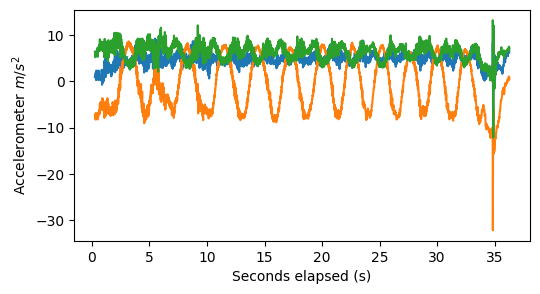

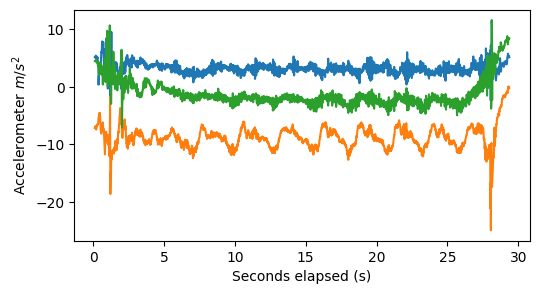

In [124]:
plot_accelerometer(curls_df)
plot_accelerometer(squat_df)

In [6]:
# Trim curls to remove the picking up of weights at the beginning of
# the set and the putting down at the end of the set
curls_df_start = curls_df[curls_df["seconds_elapsed"] == 7.0367890625].index[0]
curls_df_end = curls_df[curls_df["seconds_elapsed"] == 33.48751904296875].index[0]
curls_df_trim = curls_df.iloc[curls_df_start:curls_df_end, :]

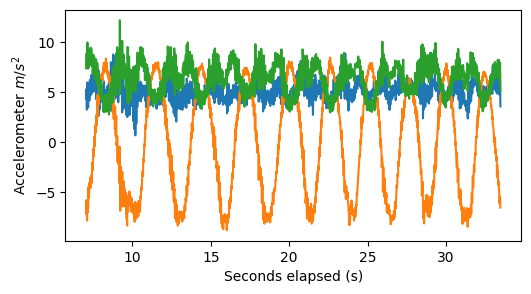

In [125]:
plot_accelerometer(curls_df_trim)

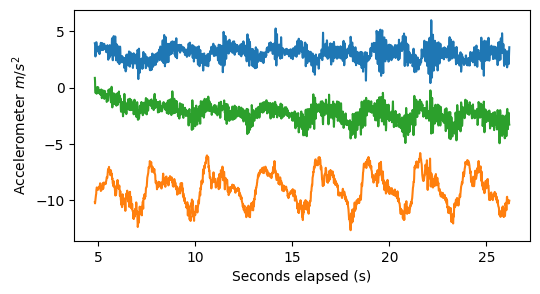

In [126]:
# Trim squats to remove the picking up of weights at the beginning of
# the set and the putting down at the end of the set
squat_df_start = squat_df[squat_df["seconds_elapsed"] == 4.837999267578125].index[0] #4.83
squat_df_end = squat_df[squat_df["seconds_elapsed"] == 26.19851220703125].index[0] #26.19
squat_df_trim = squat_df.iloc[squat_df_start:squat_df_end, :]
plot_accelerometer(squat_df_trim)

## Label data

Periods in the data representing certain motions are manually marked with the appropriate hypothesis.

|Exercise|Part|Hypothesis|
|-|-|-|
|Curls|Raising movement|$\mathcal{H}_0$|
|Curls|Lowering movement|$\mathcal{H}_0$|
|Curls|Motionless period between reps|$\mathcal{H}_0$|
|Squats|Raising movement|$\mathcal{H}_1$|
|Squats|Lowering movement|$\mathcal{H}_1$|
|Squats|Motionless period between reps|$\mathcal{H}_0$|

### Set true hypotheses on trimmed data

#### Curls

In [9]:
curls_df_trim.loc[:, 'hypothesis'] = 0
# ax = plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["hypothesis"])

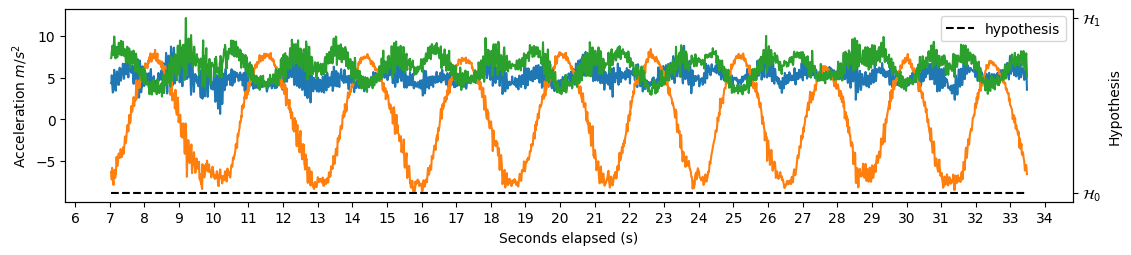

In [119]:
# Plot accelerometer data and hypothesis on the same graph
plt.figure(figsize=(13, 2.5))
plt.xlabel("Seconds elapsed (s)")
plt.ylabel("Acceleration $m/s^2$")
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["x"], label="x")
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["y"], label="y")
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["z"], label="z")

plt.twinx()
plt.ylim(-0.05, 1.05)
plt.ylabel("Hypothesis")
plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["hypothesis"], label="hypothesis", linestyle="--", color="black")
plt.legend()
plt.grid(visible=True, axis="x", linestyle="--")
a = plt.xticks(np.arange(6, 35, 1))

#### Squats

In [11]:
squat_df_trim["seconds_elapsed"] >= 0

464     True
465     True
466     True
467     True
468     True
        ... 
2389    True
2390    True
2391    True
2392    True
2393    True
Name: seconds_elapsed, Length: 1930, dtype: bool

In [12]:
# Motionless end   - idx 0
# Bottom of rep 1  - 7.03787s - H1 - 7.037873779296875
# Top of rep 1     - 7.75819s - H1 - 7.75818505859375
# Motionless end 1 - 9.32852s - H0 - 9.328517822265624
# Bottom of rep 2  - 9.76746s - H1 - 9.7674619140625
# Top of rep 2     - 10.5975s - H1 - 10.597513916015625
# Motionless end 2 - 11.9576s - H0 - 11.957637939453125
# Bottom of rep 3  - 12.7275s - H1 - 12.727472900390625
# Top of rep 3     - 13.618s  - H1 - 13.618012939453125
# Motionless end 3 - 14.9384s - H0 - 14.93835205078125
# Bottom of rep 4  - 15.8475s - H1 - 15.8475068359375
# Top of rep 4     - 16.4283s - H1 - 16.428326904296874
# Motionless end 4 - 17.368s  - H0 - 17.36797705078125
# Bottom of rep 5  - 18.2379s - H1 - 18.237943115234376
# Top of rep 5     - 18.938s  - H1 - 18.938011962890624
# Motionless end 5 - 20.1391s - H0 - 20.139137939453125
# Bottom of rep 6  - 21.0387s - H1 - 21.03868115234375
# Top of rep 6     - 21.6189s - H1 - 21.618908935546877
# Motionless end 6 - 22.5000s - H0 - 22.507530029296873
# Bottom of rep 6  - 23.2380s - H1 - 23.2380419921875
# Top of rep 7     - 24.0281s - H1 - 24.028087158203125
# Motionless end 7 - 25.0486s - H0 - 25.048609130859376
# Bottom of rep 8  - 25.7177s - H1 - 25.71772119140625
# Top of rep 8     - 26.7175s - H1 - 26.717465087890623
# Motionless end 8 - 27.5377s - H0 - 27.537717041015625

conds = [
    (squat_df_trim["seconds_elapsed"] >= 0.0)                & (squat_df_trim["seconds_elapsed"] < 7.037873779296875),
    (squat_df_trim["seconds_elapsed"] >= 7.037873779296875) & (squat_df_trim["seconds_elapsed"] < 7.75818505859375),
    (squat_df_trim["seconds_elapsed"] >= 7.75818505859375) & (squat_df_trim["seconds_elapsed"] < 9.328517822265624),
    (squat_df_trim["seconds_elapsed"] >= 9.328517822265624) & (squat_df_trim["seconds_elapsed"] < 9.7674619140625),
    (squat_df_trim["seconds_elapsed"] >= 9.7674619140625) & (squat_df_trim["seconds_elapsed"] < 10.597513916015625),
    (squat_df_trim["seconds_elapsed"] >= 10.597513916015625) & (squat_df_trim["seconds_elapsed"] < 11.957637939453125),
    (squat_df_trim["seconds_elapsed"] >= 11.957637939453125) & (squat_df_trim["seconds_elapsed"] < 12.727472900390625),
    (squat_df_trim["seconds_elapsed"] >= 12.727472900390625) & (squat_df_trim["seconds_elapsed"] < 13.618012939453125),
    (squat_df_trim["seconds_elapsed"] >= 13.618012939453125) & (squat_df_trim["seconds_elapsed"] < 14.93835205078125),
    (squat_df_trim["seconds_elapsed"] >= 14.93835205078125) & (squat_df_trim["seconds_elapsed"] < 15.8475068359375),
    (squat_df_trim["seconds_elapsed"] >= 15.8475068359375) & (squat_df_trim["seconds_elapsed"] < 16.428326904296874),
    (squat_df_trim["seconds_elapsed"] >= 16.428326904296874) & (squat_df_trim["seconds_elapsed"] < 17.36797705078125),
    (squat_df_trim["seconds_elapsed"] >= 17.36797705078125) & (squat_df_trim["seconds_elapsed"] < 18.237943115234376),
    (squat_df_trim["seconds_elapsed"] >= 18.237943115234376) & (squat_df_trim["seconds_elapsed"] < 18.938011962890624),
    (squat_df_trim["seconds_elapsed"] >= 18.938011962890624) & (squat_df_trim["seconds_elapsed"] < 20.139137939453125),
    (squat_df_trim["seconds_elapsed"] >= 20.139137939453125) & (squat_df_trim["seconds_elapsed"] < 21.03868115234375),
    (squat_df_trim["seconds_elapsed"] >= 21.03868115234375) & (squat_df_trim["seconds_elapsed"] < 21.618908935546877),
    (squat_df_trim["seconds_elapsed"] >= 21.618908935546877) & (squat_df_trim["seconds_elapsed"] < 22.507530029296873),
    (squat_df_trim["seconds_elapsed"] >= 22.507530029296873) & (squat_df_trim["seconds_elapsed"] < 23.2380419921875),
    (squat_df_trim["seconds_elapsed"] >= 23.2380419921875)& (squat_df_trim["seconds_elapsed"] < 24.028087158203125),
    (squat_df_trim["seconds_elapsed"] >= 24.028087158203125) & (squat_df_trim["seconds_elapsed"] < 25.048609130859376),
    (squat_df_trim["seconds_elapsed"] >= 25.048609130859376) & (squat_df_trim["seconds_elapsed"] < 25.71772119140625),
    (squat_df_trim["seconds_elapsed"] >= 25.71772119140625) & (squat_df_trim["seconds_elapsed"] < 26.717465087890623),
    (squat_df_trim["seconds_elapsed"] >= 26.717465087890623) & (squat_df_trim["seconds_elapsed"] < 27.537717041015625),
]

values = [1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0]
true_hyps = np.select(conds, values)
squat_df_trim.loc[:, 'hypothesis'] = true_hyps

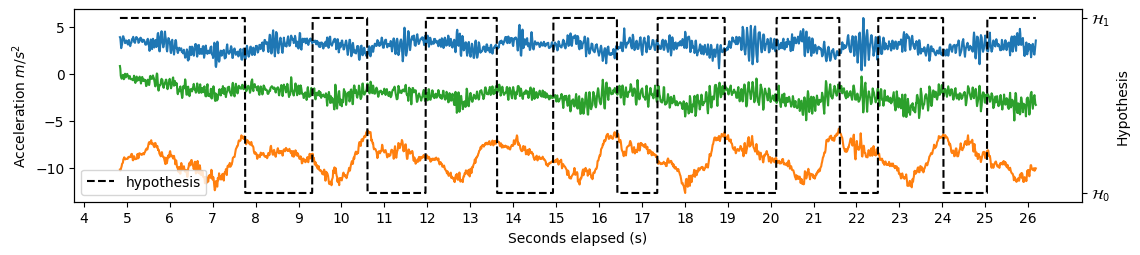

In [117]:
# Plot accelerometer data and hypothesis on the same graph
plt.figure(figsize=(13, 2.5))
plt.xlabel("Seconds elapsed (s)")
plt.ylabel("Acceleration $m/s^2$")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["x"], label="x")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["y"], label="y")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["z"], label="z")

plt.twinx()
plt.ylim(-0.05, 1.05)
plt.ylabel("Hypothesis")
plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
plt.plot(squat_df_trim["seconds_elapsed"], np.select(conds, values), label="hypothesis", linestyle="--", color="black")
plt.legend()
plt.grid(visible=True, axis="x", linestyle="--")
a= plt.xticks(np.arange(4, 27, 1))

## Compute test statistics

In [14]:
def SSM(vector):
    """Return the skew symmetric matrix [a]_x for a vector a such that [a]_x b = a x b"""
    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[1]],
            [vector[1], vector[0], 0],
        ]
    )


def calc_min_ev(alpha_beta_gamma: tuple[3], y):
    """Calculate the minimum eigenvalue
    This function will be minimized on the direction of gravity

    y is a sliding window about a certain measurement"""
    u_g = np.array(alpha_beta_gamma)
    g = 9.81

    M = np.zeros((3, 3))
    for y_k in y:  # [x, y, z]
        measurement = y_k + (g * u_g)
        M += SSM(measurement).T * SSM(measurement)

    if np.isnan(np.ravel(M)).any():
        return 9999999999999999999

    eigvs, _ = np.linalg.eig(M)
    return min(eigvs)

In [15]:
def optimise_u_g(y, guess=(0.1, 0.1, 0.1)):
    """Use scipy to optimise the alpha and beta for the min min eig"""
    res = scipy.optimize.minimize(
        fun=calc_min_ev,
        x0=guess,
        args=(y,),
        constraints=[{"type": "eq", "fun": lambda x: np.sum(np.array(x) ** 2) - 1}],
        method="trust-constr",
    )
    return res

In [16]:
def decide_on_hypothesis(test_statistics, gamma):
    """Decide on hypothesis at each point."""
    return test_statistics > gamma

def calc_true_positives(decisions, true_hyps):
    """Calculate the proportion of H1 (translational motion) that were correctly identified."""
    return np.mean((decisions == 1) & (true_hyps == 1))

def calc_false_positives(decisions, true_hyps):
    """Calculate the proportion of H0 (no translational motion) that were incorrectly identified as H1."""
    return np.mean((decisions == 1) & (true_hyps == 0))

def calc_true_negatives(decisions, true_hyps):
    """Calculate the proportion of H0 (no translational motion) that were correctly identified."""
    return np.mean((decisions == 0) & (true_hyps == 0))

def calc_false_negatives(decisions, true_hyps):
    """Calculate the proportion of H1 (translational motion) that were incorrectly identified as H0."""
    return np.mean((decisions == 0) & (true_hyps == 1))

def plot_hypotheses(x, hypotheses, left_lim, right_lim, s=None, color="tab:blue"):
    plt.ylim(-0.1, 1.1)
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.xticks(np.arange(left_lim, right_lim, 1))
    plt.grid(axis="x", linestyle="--")
    plt.xlim(left_lim, right_lim)
    ax = plt.scatter(x, hypotheses, s=s, color=color)
    return ax

In [17]:
def measurement_window(measurements, n, stride=1):
    """
    Create sliding windows of size 'n' from the measurements data.

    Parameters:
    measurements (DataFrame): The input measurements data.
    n (int): The size of the sliding window.
    stride (int, optional): The stride value for the sliding window. Defaults to 1.

    Returns:
    ndarray: The sliding windows of size 'n' from the measurements data.
    """
    x_sw = sliding_window_view(measurements["x"].to_numpy(), n)
    y_sw = sliding_window_view(measurements["y"].to_numpy(), n)
    z_sw = sliding_window_view(measurements["z"].to_numpy(), n)

    # Combine x, y and z into 3D vectors for each measurement in the sliding window
    sw = np.stack((x_sw, y_sw, z_sw), axis=-1)
    return sw[::stride]

# sw_100[k] is the kth window of 100 measurements
# sw_100[k][j] is the jth measurement in the kth window
# sw_100[k][j][i] is the ith coordinate of the jth measurement in the kth window

In [18]:
def min_min_evs(windows):
    """Calculate the minimum of the minimum eigenvalues for each window"""
    Ts = []  # min min eigs

    for window in windows:
        res = optimise_u_g(window)
        min_min_ev = res.fun
        Ts.append(min_min_ev)

    return Ts

In [19]:
squat_window_stride = 10
squat_window_size = 100
curl_window_stride = 10
curl_window_size = 100

In [20]:
# squat_Ts = min_min_evs(measurement_window(squat_df_trim, squat_window_size, stride=squat_window_stride))
squat_Ts = pd.read_csv("data/sam/squat_Ts_stride_10_size_100.csv").to_numpy().flatten()

In [21]:
# curl_Ts = min_min_evs(measurement_window(curls_df_trim, curl_window_size, stride=curl_window_stride))
curl_Ts = pd.read_csv("./data/sam/curl_Ts_stride_10_size_100.csv").to_numpy().flatten()

In [22]:
# Create a copy of both dataframes with stride and trimmed to the correct length
squat_df_trim_s10 = squat_df_trim[::squat_window_stride]
curls_df_trim_s10 = curls_df_trim[::curl_window_stride]
# Trim to length of Ts
squat_df_trim_s10 = squat_df_trim_s10[:len(squat_Ts)]
curls_df_trim_s10 = curls_df_trim_s10[:len(curl_Ts)]

print("Squats")
print(squat_df_trim_s10.shape)
print(pd.Series(squat_Ts).shape)

print()

print("Curls")
print(curls_df_trim_s10.shape)
print(pd.Series(curl_Ts).shape)

Squats
(184, 6)
(184,)

Curls
(231, 6)
(231,)


## Plot test statistics

In [23]:
def eigplot_double(Ts_1, Ts_2, title1, title2, window_size1, window_size2, window_stride1, window_stride2, suptitle):
    # Exploratory eigenvalue plot
    plt.figure(figsize=(15, 4))
    plt.suptitle(suptitle)

    plt.subplot(1, 2, 1)
    plt.title(f"{title1} (window size={window_size1}, stride={window_stride1})")
    plt.ylabel("Min min eigenvalue")
    ax = pd.Series(Ts_1).plot(color="tab:blue")

    plt.subplot(1, 2, 2)
    plt.title(f"{title2} (window size={window_size2}, stride={window_stride2})")
    ax = pd.Series(Ts_2).plot(color="tab:orange")

In [24]:
def eigplot_two_together(Ts_1, Ts_2):
    plt.ylabel("Min min eigenvalue")
    plt.xticks([])
    ax = pd.Series(Ts_1).plot(color="tab:blue")
    ax = pd.Series(Ts_2).plot(color="tab:orange")

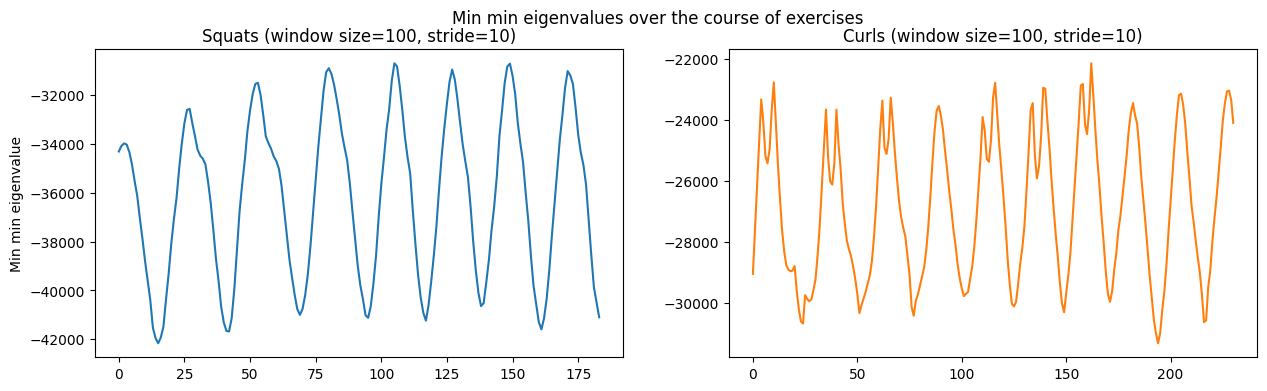

In [25]:
# Exploratory eigenvalue plot
eigplot_double(
    squat_Ts,
    curl_Ts,
    "Squats",
    "Curls",
    squat_window_size,
    curl_window_size,
    squat_window_stride,
    curl_window_stride,
    "Min min eigenvalues over the course of exercises",
)

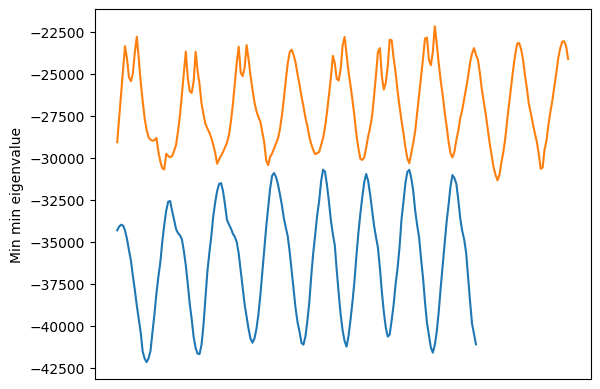

In [26]:
eigplot_two_together(squat_Ts, curl_Ts)

Clear separation visible

## Grid search gammas

In [27]:
def grid_search_gammas(Ts, true_hyps, left, right, step):
    """Grid search for the best gamma."""
    gammas = np.arange(left, right, step)
    accs_arr = []
    true_pos_arr = []
    false_pos_arr = []
    true_neg_arr = []
    false_neg_arr = []
    hyp_sets = []

    for gamma in gammas:
        decisions = decide_on_hypothesis(Ts, gamma)

        accs_arr.append(accuracy_score(true_hyps, decisions))
        tp = calc_true_positives(decisions, true_hyps)
        fp = calc_false_positives(decisions, true_hyps)
        tn = calc_true_negatives(decisions, true_hyps)
        fn = calc_false_negatives(decisions, true_hyps)
        
        if tp == 0:
            tpr = 0 # divide by zero doesn't matter because numerator is 0 anyway
        else:
            tpr = tp/(tp+fn)
        if fp == 0:
            fpr = 0 # divide by zero doesn't matter because numerator is 0 anyway
        else:
            fpr = fp/(fp+tn)

        tnr = 1 - fpr
        fnr = 1 - tpr
        
        true_pos_arr.append(tpr)
        false_pos_arr.append(fpr)
        true_neg_arr.append(tnr)
        false_neg_arr.append(fnr)

        hyp_sets.append(decisions)

    return gammas, accs_arr, true_pos_arr, false_pos_arr, true_neg_arr, false_neg_arr, hyp_sets

#### Squats

In [28]:
# Grid search thresholds
# squat_gamma_lower = -50_000
# squat_gamma_upper = -20_000
squat_gamma_lower = np.min(squat_Ts)
squat_gamma_upper = np.max(squat_Ts)
squat_gamma_step = 1

(
    squat_gammas,
    squat_accs_arr,
    squat_true_pos_arr,
    squat_false_pos_arr,
    squat_true_neg_arr,
    squat_false_neg_arr,
    squat_hyp_sets,
) = grid_search_gammas(
    squat_Ts,
    squat_df_trim_s10["hypothesis"].values,
    squat_gamma_lower,
    squat_gamma_upper,
    squat_gamma_step,
)

#### Curls

In [29]:
# Grid search thresholds
# curl_gamma_lower = -35_000
# curl_gamma_upper = -20_000
curl_gamma_lower = np.min(curl_Ts)
curl_gamma_upper = np.max(curl_Ts)
curl_gamma_step = 1
(
    curl_gammas,
    curl_accs_arr,
    curl_true_pos_arr,
    curl_false_pos_arr,
    curl_true_neg_arr,
    curl_false_neg_arr,
    curl_hyp_sets,
) = grid_search_gammas(
    curl_Ts,
    curls_df_trim_s10["hypothesis"].values,
    curl_gamma_lower,
    curl_gamma_upper,
    curl_gamma_step,
)

## Plot classification metrics

In [30]:
def plot_class_metrics(gammas, true_pos_arr, false_pos_arr, true_neg_arr, false_neg_arr):
    """Plot the classification metrics."""
    plt.subplot(2, 2, 1)
    plt.title("True positive rate (sensitivity)")
    plt.xlabel("$ \gamma $")
    plt.plot(gammas, true_pos_arr, color="tab:blue")
    plt.subplot(2, 2, 2)
    plt.title("False positive rate (1 - specificity)")
    plt.xlabel("$ \gamma $")
    plt.plot(gammas, false_pos_arr, color="tab:orange")
    plt.subplot(2, 2, 3)
    plt.title("True negative rate (specificity)")
    plt.xlabel("$ \gamma $")
    plt.plot(gammas, true_neg_arr, color="tab:green")
    plt.subplot(2, 2, 4)
    plt.title("False negative rate (1 - sensitivity)")
    plt.xlabel("$ \gamma $")
    plt.plot(gammas, false_neg_arr, color="tab:red")
    plt.tight_layout()

#### Squats

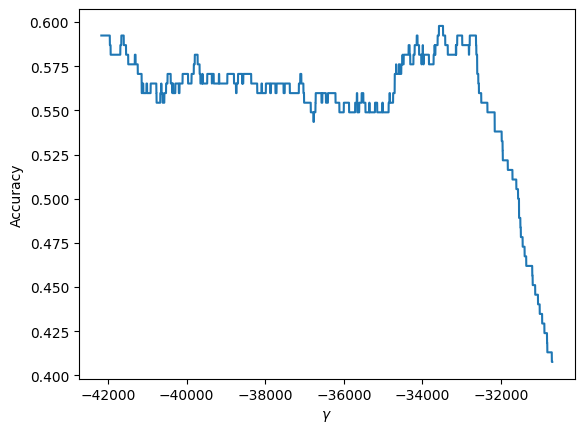

In [31]:
plt.xlabel("$\gamma$")
plt.ylabel("Accuracy")
ax = plt.plot(squat_gammas, squat_accs_arr)

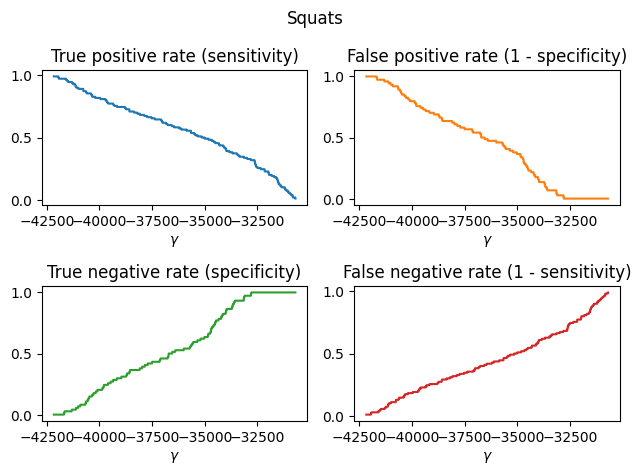

In [32]:
# Plot metrics for squats
t = plt.suptitle("Squats")
plot_class_metrics(
    squat_gammas,
    squat_true_pos_arr,
    squat_false_pos_arr,
    squat_true_neg_arr,
    squat_false_neg_arr,
)

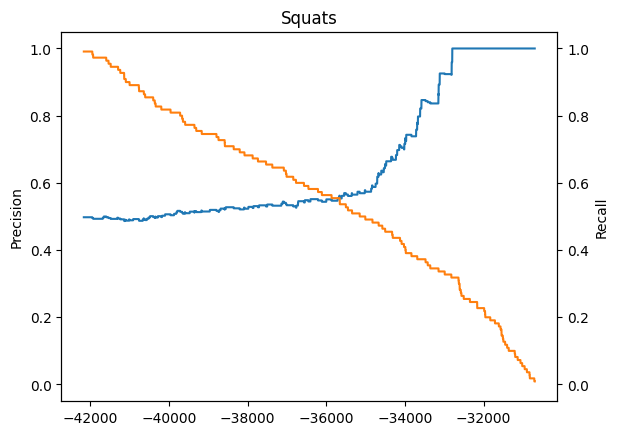

In [33]:
# Precision & recall
squat_precisions = np.array(squat_true_pos_arr) / (
    np.array(squat_true_pos_arr) + np.array(squat_false_pos_arr)
)
np.nan_to_num(squat_precisions, copy=False, nan=1.0)
squat_recalls = np.array(squat_true_pos_arr) / (
    np.array(squat_true_pos_arr) + np.array(squat_false_neg_arr)
)
np.nan_to_num(squat_recalls, copy=False, nan=1.0)
squat_f1_scores = 2 * (squat_precisions * squat_recalls) / (squat_precisions + squat_recalls)
plt.title("Squats")
plt.ylabel("Precision")
plt.ylim(-0.05, 1.05)
plt.twinx()
plt.xlabel("$ \gamma $")
plt.plot(squat_gammas, squat_precisions, color="tab:blue")
plt.ylabel("Recall")
plt.plot(squat_gammas, squat_recalls, color="tab:orange")
l = plt.ylim(-0.05, 1.05)

#### Curls

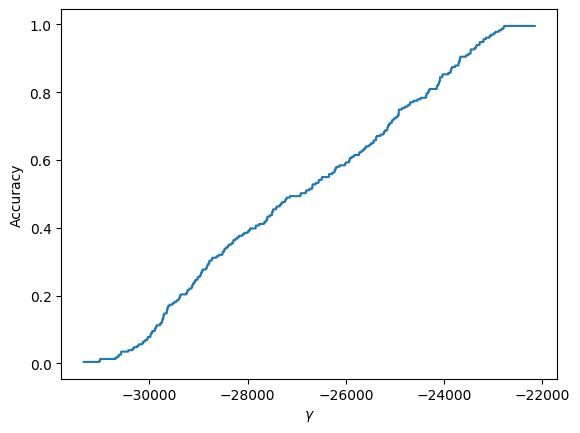

In [34]:
plt.xlabel("$\gamma$")
plt.ylabel("Accuracy")
ax = plt.plot(curl_gammas, curl_accs_arr)

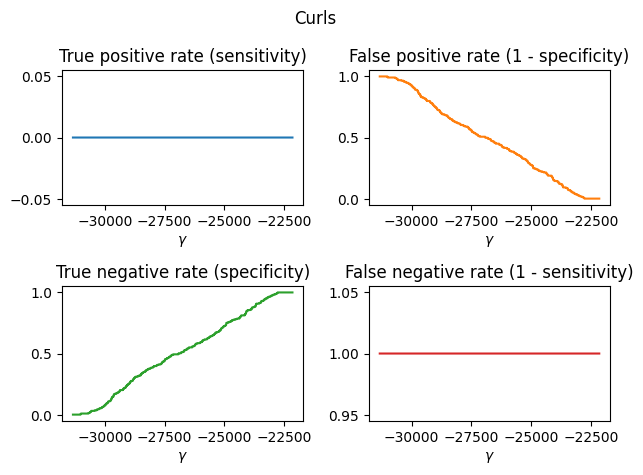

In [35]:
# Plot metrics for curls
t = plt.suptitle("Curls")
plot_class_metrics(
    curl_gammas,
    curl_true_pos_arr,
    curl_false_pos_arr,
    curl_true_neg_arr,
    curl_false_neg_arr,
)

/tmp/ipykernel_17319/295626745.py:10: RuntimeWarning: invalid value encountered in divide
  curl_f1_scores = 2 * (curl_precisions * curl_recalls) / (curl_precisions + curl_recalls)


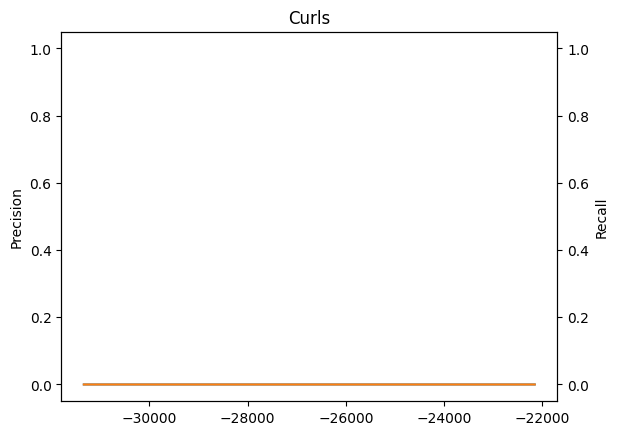

In [36]:
# Precision & recall
curl_precisions = np.array(curl_true_pos_arr) / (
    np.array(curl_true_pos_arr) + np.array(curl_false_pos_arr)
)
np.nan_to_num(curl_precisions, copy=False, nan=1.0)
curl_recalls = np.array(curl_true_pos_arr) / (
    np.array(curl_true_pos_arr) + np.array(curl_false_neg_arr)
)
np.nan_to_num(curl_recalls, copy=False, nan=1.0)
curl_f1_scores = 2 * (curl_precisions * curl_recalls) / (curl_precisions + curl_recalls)
plt.title("Curls")
plt.ylabel("Precision")
plt.ylim(-0.05, 1.05)
plt.twinx()
plt.xlabel("$ \gamma $")
plt.plot(curl_gammas, curl_precisions, color="tab:blue")
plt.ylabel("Recall")
plt.plot(curl_gammas, curl_recalls, color="tab:orange")
l = plt.ylim(-0.05, 1.05)

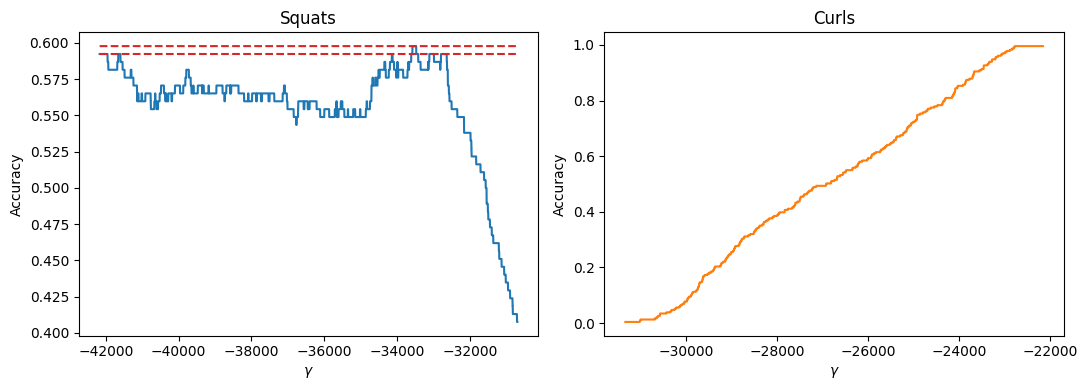

In [37]:
plt.figure(figsize=(11, 4))

# Squats
plt.subplot(1, 2, 1)
plt.title("Squats")
plt.xlabel("$\gamma$")
plt.ylabel("Accuracy")
plt.plot(squat_gammas, squat_accs_arr, color="tab:blue")
# Plot horizontal dashed red lines at first point on the line and the highest point of the line
plt.plot(
    squat_gammas,
    np.ones(squat_gammas.shape) * squat_accs_arr[0],
    linestyle="--",
    color="tab:red",
)
plt.plot(
    squat_gammas,
    np.ones(squat_gammas.shape) * np.max(squat_accs_arr),
    linestyle="--",
    color="tab:red",
)

# Curls
plt.subplot(1, 2, 2)
plt.title("Curls")
plt.xlabel("$\gamma$")
plt.ylabel("Accuracy")
plt.plot(curl_gammas, curl_accs_arr, color="tab:orange")
plt.tight_layout()

In [38]:
print(f"The first value in accuracies: {squat_accs_arr[0]}")
print(f"The highest accuracy: {np.max(squat_accs_arr)}")
print(f"The proportion of hypotheses that are 1: {np.mean(squat_df_trim_s10['hypothesis'])}")

The first value in accuracies: 0.592391304347826
The highest accuracy: 0.5978260869565217
The proportion of hypotheses that are 1: 0.5978260869565217


## Plot hypotheses

In [39]:
dot_size = 30

In [40]:
def side_by_side_hyps(x, y1, y2, left, right, s=1):
    """Plot two sets of hypotheses side by side."""
    fig = plt.figure(figsize=(15, 3))
    fig.supylabel("Hypothesis")
    fig.supxlabel("Seconds elapsed (s)")

    plt.subplot(2, 1, 1)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 1))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax1 = plt.scatter(x, y1, s=s, color="tab:blue")

    plt.subplot(2, 1, 2)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 1))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax2 = plt.scatter(x, y2, s=s, color="tab:orange")
    return ax1, ax2

In [41]:
def hyps_quad_plot(x, y1, y2, y3, y4, left, right, titles, s=1):
    """Plot four sets of hypotheses in a 2x2 layout."""
    fig = plt.figure(figsize=(15, 4))
    fig.supylabel("Hypothesis")
    fig.supxlabel("Seconds elapsed (s)")

    plt.subplot(2, 2, 1)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax1 = plt.scatter(x, y1, s=s, color="tab:blue")
    plt.title(titles[0])

    plt.subplot(2, 2, 2)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax2 = plt.scatter(x, y2, s=s, color="tab:orange")
    plt.title(titles[1])

    plt.subplot(2, 2, 3)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y3, s=s, color="tab:green")
    plt.title(titles[2])

    plt.subplot(2, 2, 4)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y4, s=s, color="tab:red")
    plt.title(titles[3])

In [42]:
def hyps_octa_plot(x, y1, y2, y3, y4, y5, y6, y7, y8, left, right, titles, s=1):
    """Plot eight sets of hypotheses. in a 2x4 layout."""
    fig = plt.figure(figsize=(15, 4))
    fig.supylabel("Hypothesis")
    fig.supxlabel("Seconds elapsed (s)")

    plt.subplot(2, 4, 1)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax1 = plt.scatter(x, y1, s=s, color="tab:blue")
    plt.title(titles[0])

    plt.subplot(2, 4, 2)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax2 = plt.scatter(x, y2, s=s, color="tab:orange")
    plt.title(titles[1])

    plt.subplot(2, 4, 3)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y3, s=s, color="tab:green")
    plt.title(titles[2])

    plt.subplot(2, 4, 4)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y4, s=s, color="tab:red")
    plt.title(titles[3])

    plt.subplot(2, 4, 5)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y5, s=s, color="tab:purple")
    plt.title(titles[4])

    plt.subplot(2, 4, 6)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y6, s=s, color="tab:brown")
    plt.title(titles[5])

    plt.subplot(2, 4, 7)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y7, s=s, color="tab:pink")
    plt.title(titles[6])

    plt.subplot(2, 4, 8)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 2))
    plt.yticks(ticks=[0, 1], labels=["$\mathcal{H}_0$", "$\mathcal{H}_1$"])
    plt.grid(axis="x", linestyle="--")
    ax3 = plt.scatter(x, y8, s=s, color="tab:gray")
    plt.title(titles[7])

#### Squats

##### Individual plots

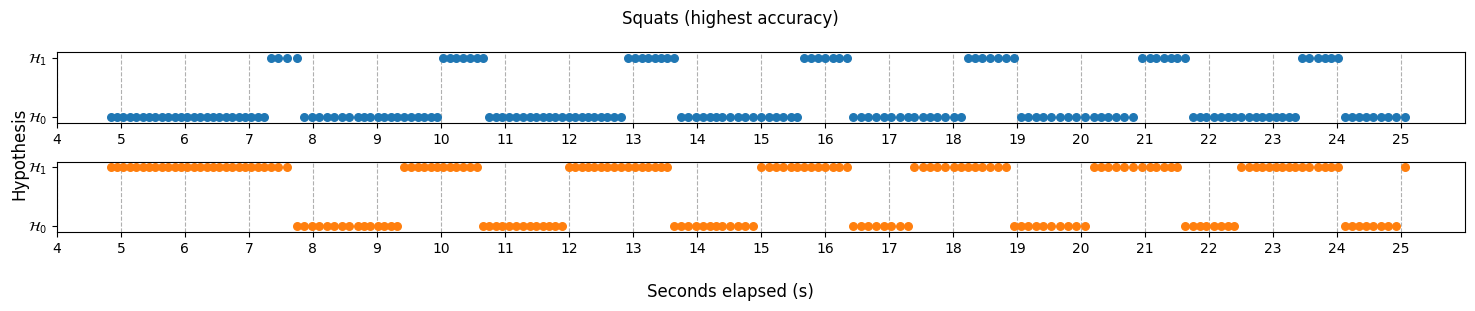

In [43]:
# Highest accuracy
# Highest true negative rate
side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_accs_arr)],
    squat_df_trim_s10["hypothesis"],
    4,
    26,
    s=dot_size
)
plt.suptitle("Squats (highest accuracy)")
plt.tight_layout()

1


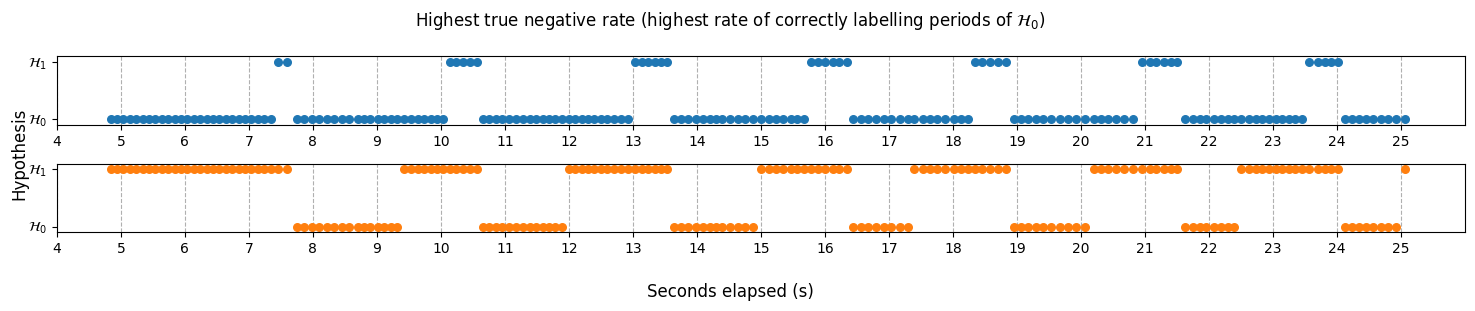

In [44]:
# Highest true negative rate
side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_true_neg_arr)],
    squat_df_trim_s10["hypothesis"],
    4,
    26,
    s=dot_size
)
plt.suptitle("Highest true negative rate (highest rate of correctly labelling periods of $\mathcal{H}_0$)")
plt.tight_layout()
print(max(squat_true_neg_arr))

1.0


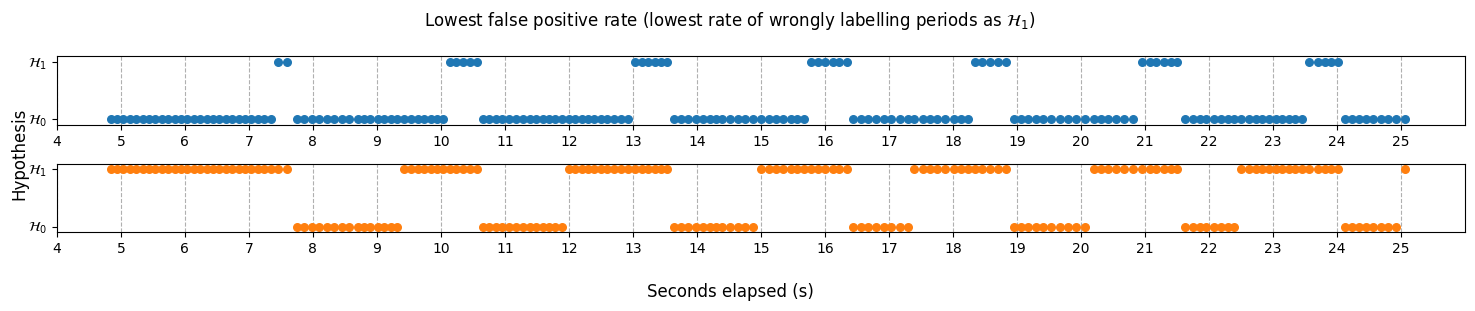

In [45]:
# Lowest false positive rate
side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmin(squat_false_pos_arr)],
    squat_df_trim_s10["hypothesis"],
    4,
    26,
    s=dot_size
)
plt.suptitle("Lowest false positive rate (lowest rate of wrongly labelling periods as $\mathcal{H}_1$)")
plt.tight_layout()
print(max(squat_false_pos_arr))

0.9909090909090909


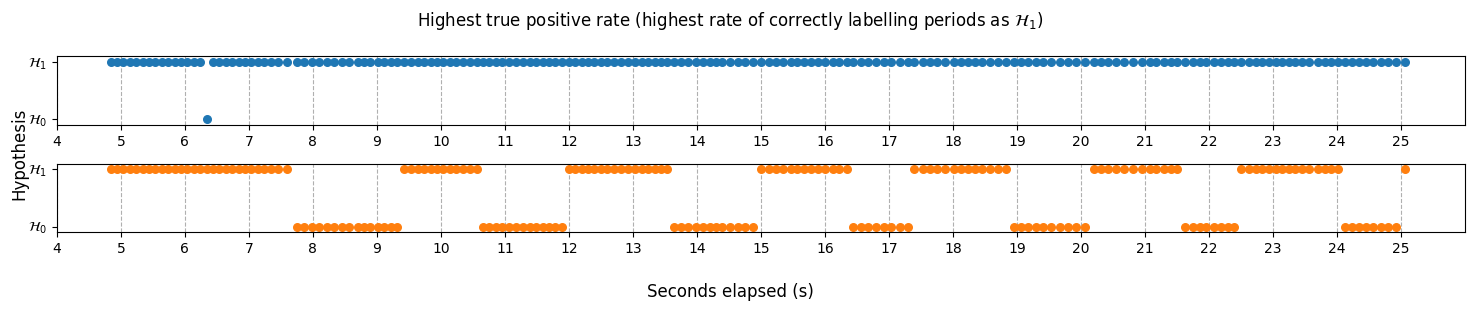

In [46]:
# Highest true positive rate
side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_true_pos_arr)],
    squat_df_trim_s10["hypothesis"],
    4,
    26,
    s=dot_size
)
plt.suptitle("Highest true positive rate (highest rate of correctly labelling periods as $\mathcal{H}_1$)")
plt.tight_layout()
print(max(squat_true_pos_arr))

0.990909090909091


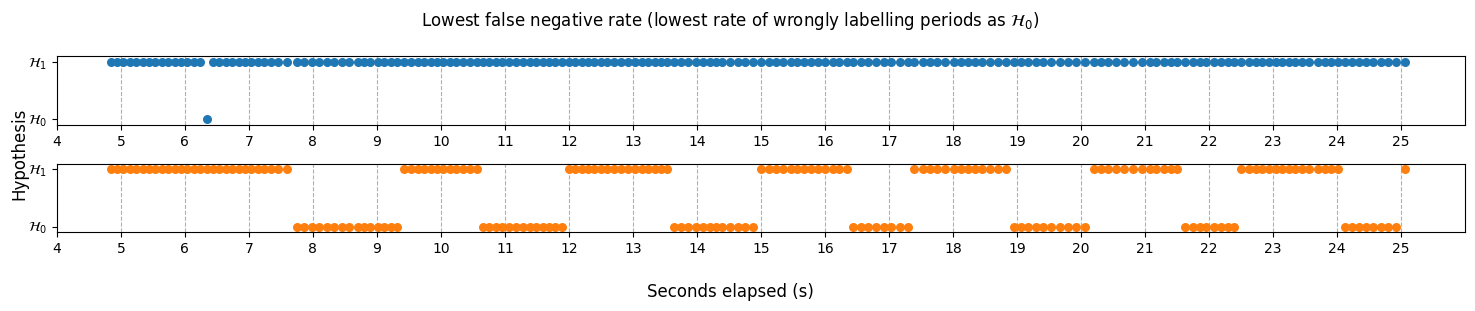

In [47]:
# Lowest false negative rate
side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmin(squat_false_neg_arr)],
    squat_df_trim_s10["hypothesis"],
    4,
    26,
    s=dot_size
)
plt.suptitle("Lowest false negative rate (lowest rate of wrongly labelling periods as $\mathcal{H}_0$)")
plt.tight_layout()
print(max(squat_false_neg_arr))

1.0


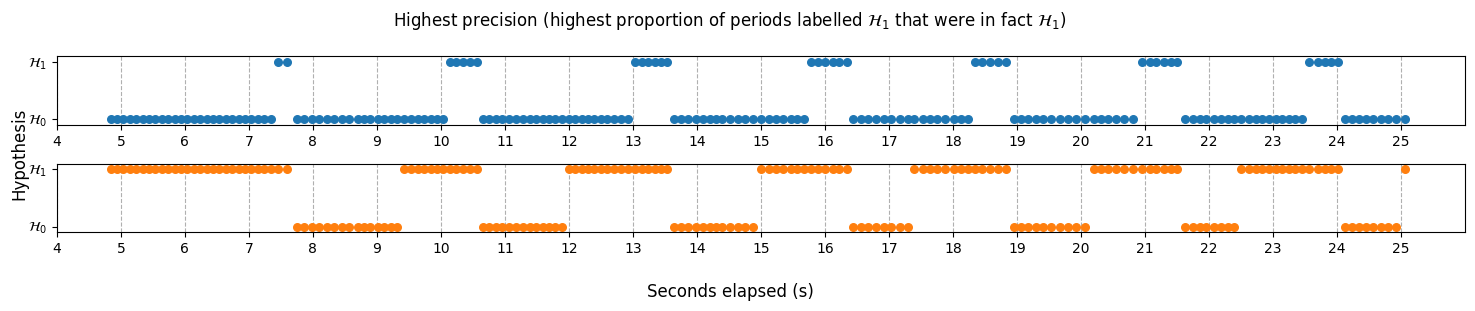

In [48]:
# Highest precision
side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_precisions)],
    squat_df_trim_s10["hypothesis"],
    4,
    26,
    s=dot_size
)
plt.suptitle("Highest precision (highest proportion of periods labelled $\mathcal{H}_1$ that were in fact $\mathcal{H}_1$)")
plt.tight_layout()
print(max(squat_precisions))

0.9909090909090909


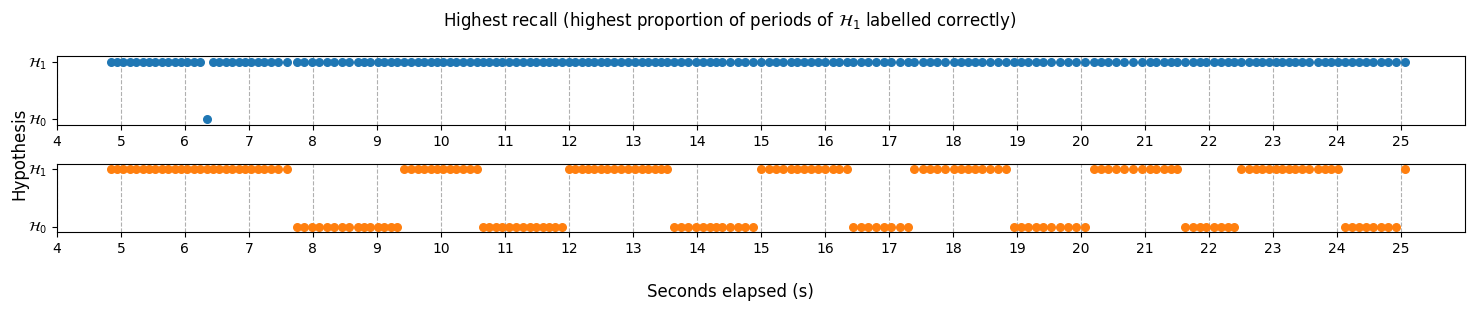

In [49]:
# Highest recall
side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_recalls)],
    squat_df_trim_s10["hypothesis"],
    4,
    26,
    s=dot_size
)
# how many of the H1s were correctly identified as H1
plt.suptitle("Highest recall (highest proportion of periods of $\mathcal{H}_1$ labelled correctly)")
plt.tight_layout()
print(max(squat_recalls))

0.662613981762918


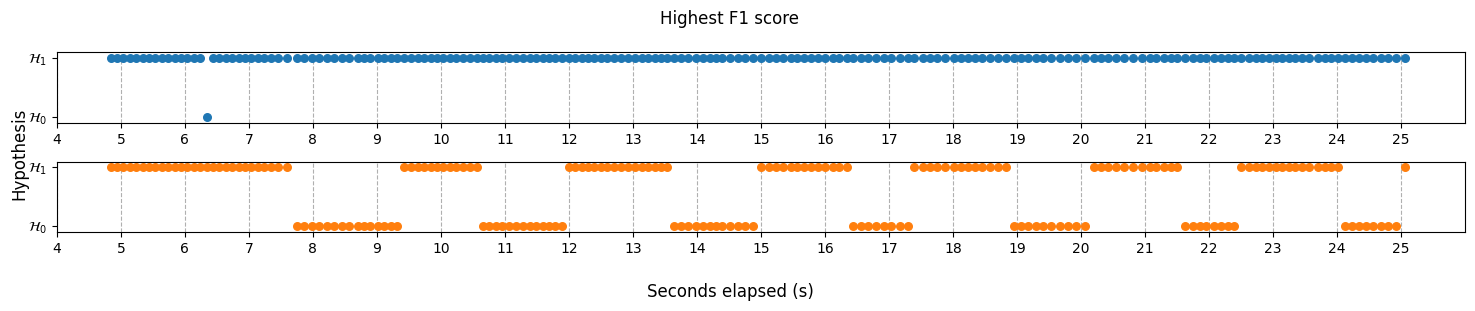

In [50]:
# Highest F1 score
side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_f1_scores)],
    squat_df_trim_s10["hypothesis"],
    4,
    26,
    s=dot_size
)
plt.suptitle("Highest F1 score")
plt.tight_layout()
print(max(squat_f1_scores))

0.018018018018018018


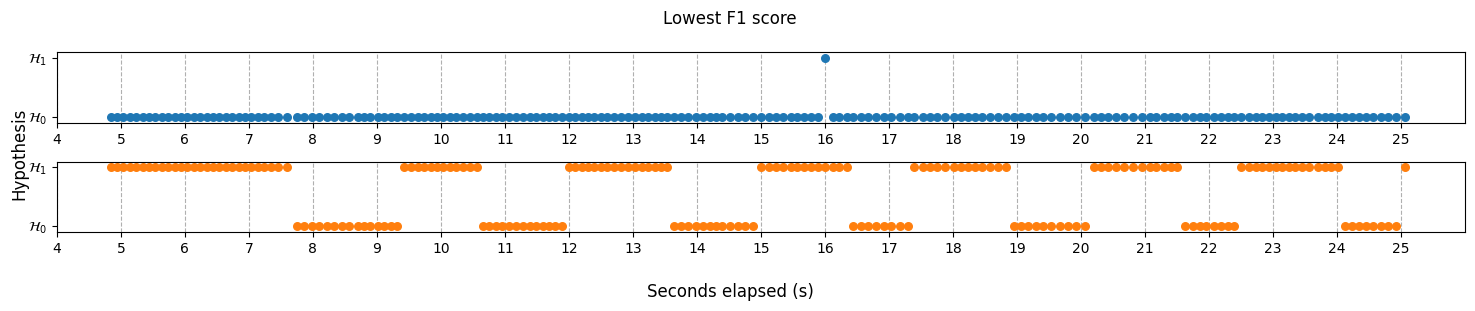

In [51]:
# Lowest F1 score
side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmin(squat_f1_scores)],
    squat_df_trim_s10["hypothesis"],
    4,
    26,
    s=dot_size
)
plt.suptitle("Lowest F1 score")
plt.tight_layout()
print(min(squat_f1_scores))

##### Octa plot

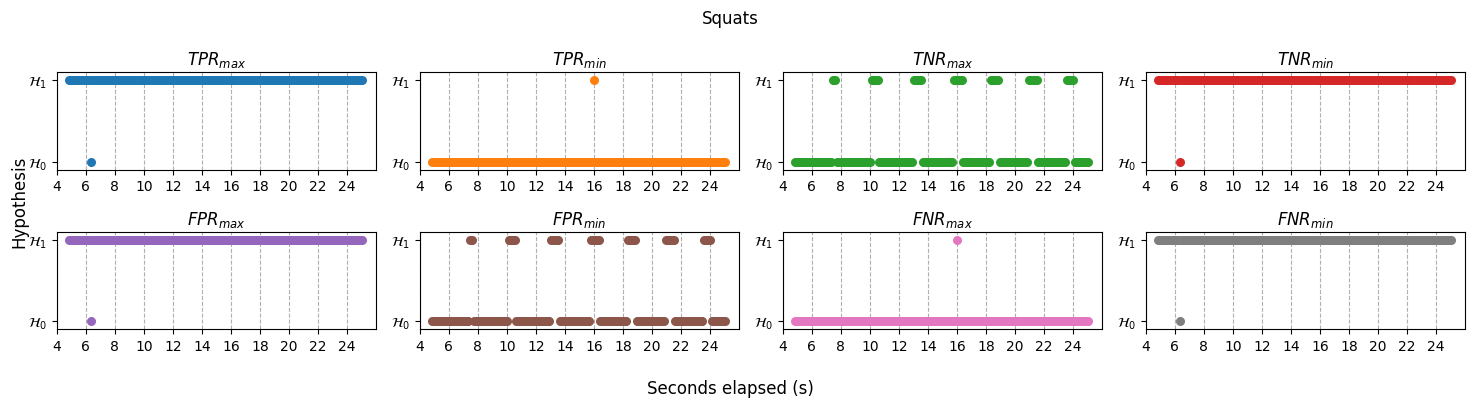

In [54]:
# Squats octa plot for max and min of all 8 metrics
hyps_octa_plot(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_true_pos_arr)],
    squat_hyp_sets[np.argmin(squat_true_pos_arr)],
    squat_hyp_sets[np.argmax(squat_true_neg_arr)],
    squat_hyp_sets[np.argmin(squat_true_neg_arr)],
    squat_hyp_sets[np.argmax(squat_false_pos_arr)],
    squat_hyp_sets[np.argmin(squat_false_pos_arr)],
    squat_hyp_sets[np.argmax(squat_false_neg_arr)],
    squat_hyp_sets[np.argmin(squat_false_neg_arr)],
    4,
    26,
    ["$TPR_{max}$", "$TPR_{min}$", "$TNR_{max}$", "$TNR_{min}$", "$FPR_{max}$", "$FPR_{min}$", "$FNR_{max}$", "$FNR_{min}$"],
    s=dot_size
)
plt.suptitle("Squats")
plt.tight_layout()

##### Key takeaways
- The classification with the **highest accuracy** presents a meaningful-looking classification.
    - The highest accuracy $\neq$ the highest true positive/lowest false positive rate.
- The classification with the **lowest false positive** rate is identical to the one with the **highest true negative** rate.
    - These make a pretty good attempt at classifying.
- The classification with the **highest true positive** rate is identical to the one with the **lowest false negative** rate.
    - These just guess $ \mathcal{H}_1 $ for every measurement window.
- The classification with the **highest precision** is identical to the lowest false positive and highest true negative.
    - The highest precision is 1.0 

#### Curls

##### Individual plots

In [55]:
curl_left_lim = 6
curl_right_lim = 33

0.9956709956709957


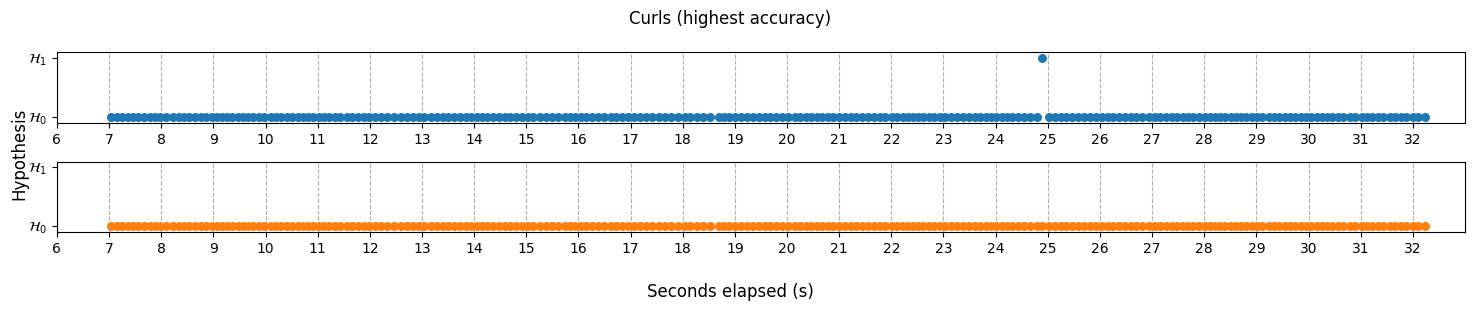

In [56]:
# Highest accuracy

side_by_side_hyps(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmax(curl_accs_arr)],
    curls_df_trim_s10["hypothesis"],
    curl_left_lim,
    curl_right_lim,
    s=dot_size
)
plt.suptitle("Curls (highest accuracy)")
plt.tight_layout()
print(max(curl_accs_arr))

0.9956709956709957


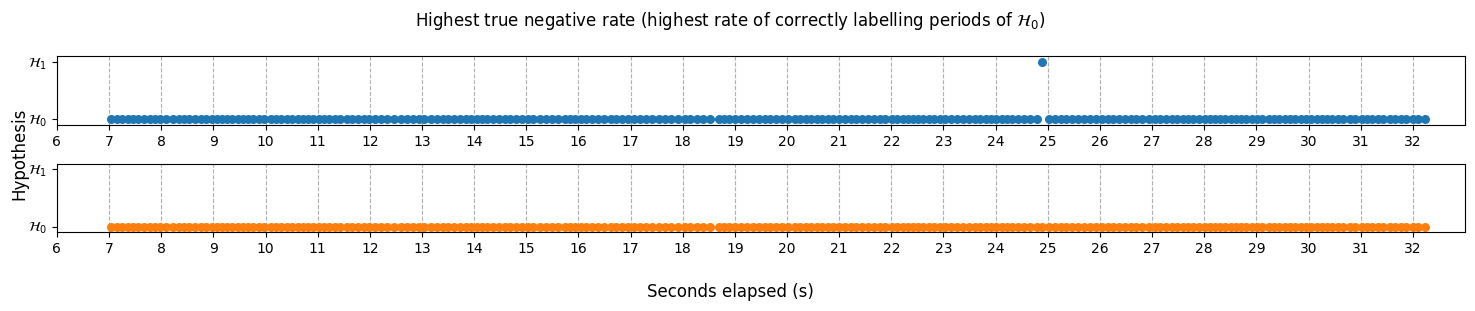

In [57]:
# Highest true negative rate
side_by_side_hyps(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmax(curl_true_neg_arr)],
    curls_df_trim_s10["hypothesis"],
    curl_left_lim,
    curl_right_lim,
    s=dot_size
)
plt.suptitle("Highest true negative rate (highest rate of correctly labelling periods of $\mathcal{H}_0$)")
plt.tight_layout()
print(max(curl_true_neg_arr))

0.9956709956709957


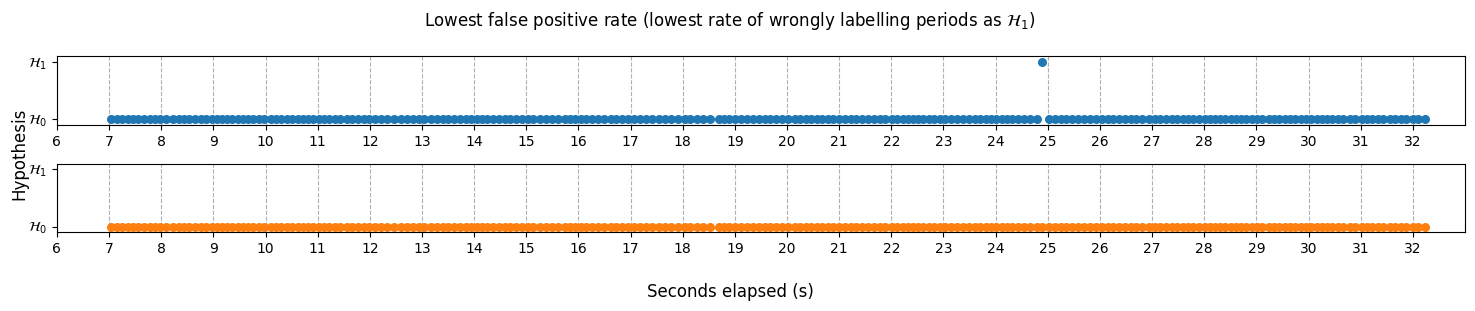

In [58]:
# Lowest false positive rate
side_by_side_hyps(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmin(curl_false_pos_arr)],
    curls_df_trim_s10["hypothesis"],
    curl_left_lim,
    curl_right_lim,
    s=dot_size
)
plt.suptitle("Lowest false positive rate (lowest rate of wrongly labelling periods as $\mathcal{H}_1$)")
plt.tight_layout()
print(max(curl_false_pos_arr))

0


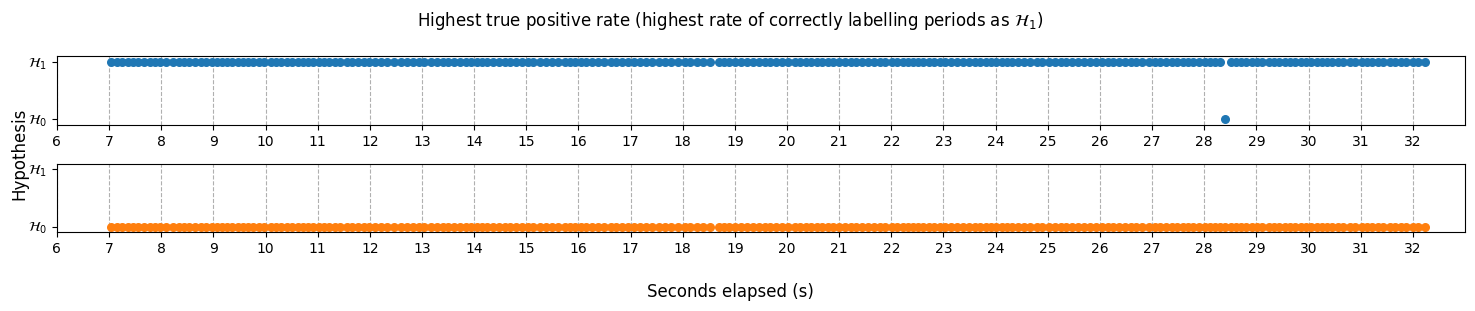

In [59]:
# Highest true positive
side_by_side_hyps(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmax(curl_true_pos_arr)],
    curls_df_trim_s10["hypothesis"],
    curl_left_lim,
    curl_right_lim,
    s=dot_size
)
plt.suptitle("Highest true positive rate (highest rate of correctly labelling periods as $\mathcal{H}_1$)")
plt.tight_layout()
print(max(curl_true_pos_arr))

1


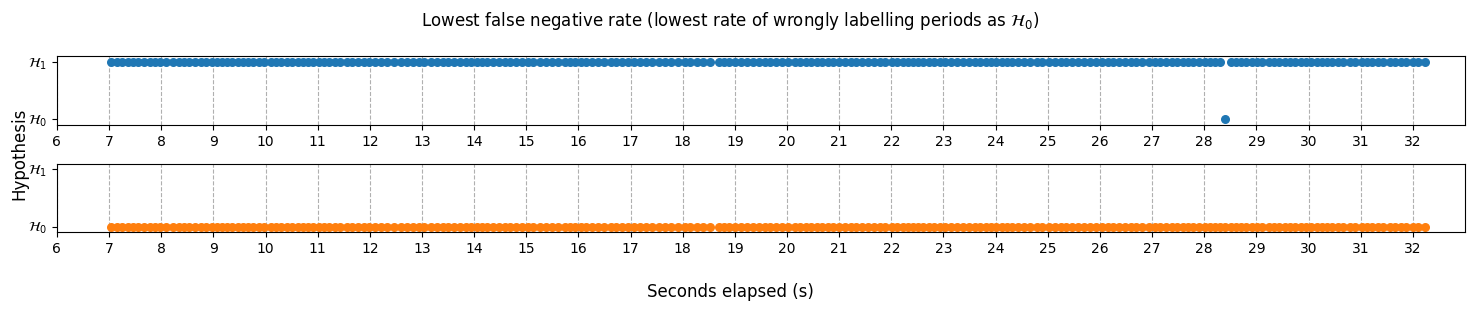

In [60]:
# Lowest false negative
side_by_side_hyps(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmin(curl_false_neg_arr)],
    curls_df_trim_s10["hypothesis"],
    curl_left_lim,
    curl_right_lim,
    s=dot_size
)
plt.suptitle("Lowest false negative rate (lowest rate of wrongly labelling periods as $\mathcal{H}_0$)")
plt.tight_layout()
print(max(curl_false_neg_arr))

0.0


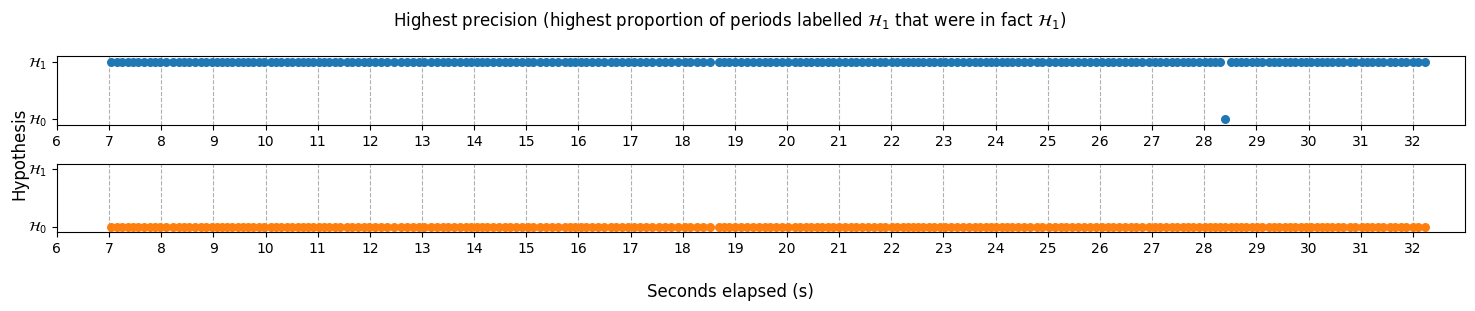

In [61]:
# Highest precision
side_by_side_hyps(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmax(curl_precisions)],
    curls_df_trim_s10["hypothesis"],
    curl_left_lim,
    curl_right_lim,
    s=dot_size
)
plt.suptitle("Highest precision (highest proportion of periods labelled $\mathcal{H}_1$ that were in fact $\mathcal{H}_1$)")
plt.tight_layout()
print(max(curl_precisions))

0.0


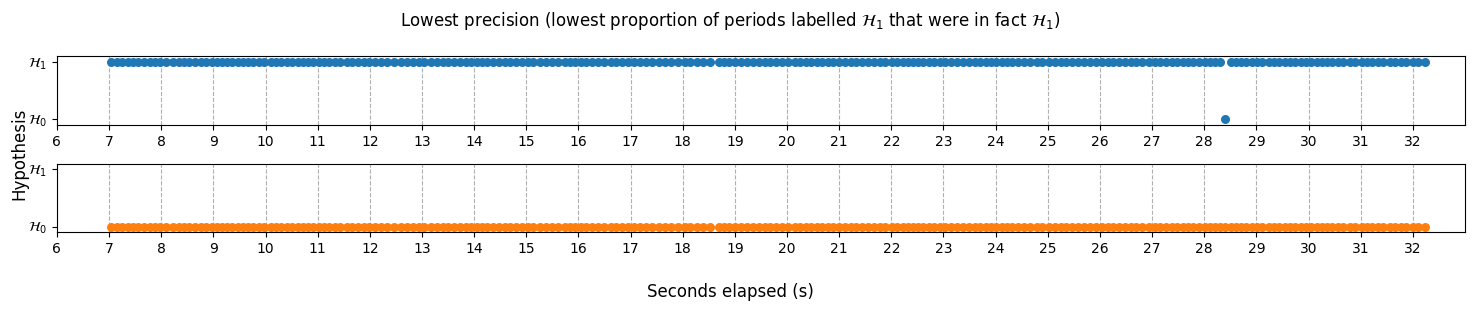

In [62]:
# Lowest precision
side_by_side_hyps(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmin(curl_precisions)],
    curls_df_trim_s10["hypothesis"],
    curl_left_lim,
    curl_right_lim,
    s=dot_size
)
plt.suptitle("Lowest precision (lowest proportion of periods labelled $\mathcal{H}_1$ that were in fact $\mathcal{H}_1$)")
plt.tight_layout()
print(min(curl_precisions))

0.0


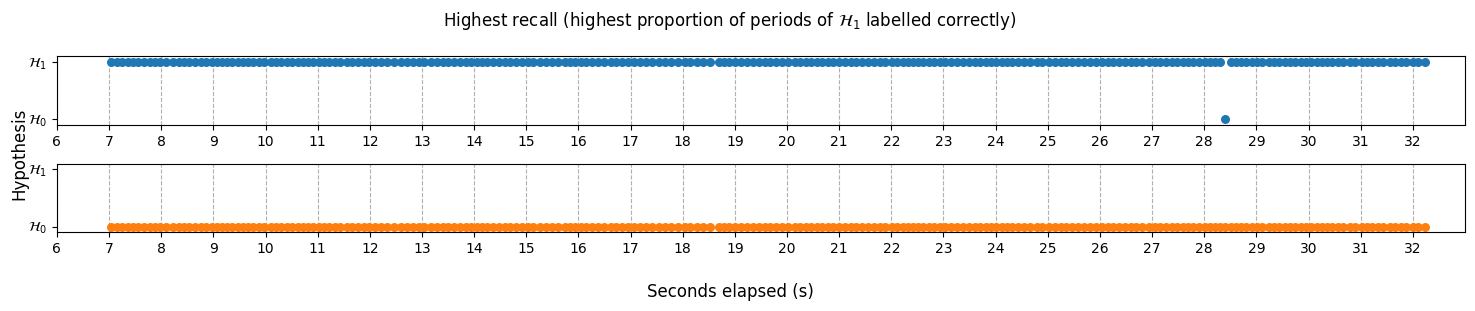

In [63]:
# Highest recall
side_by_side_hyps(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmax(curl_recalls)],
    curls_df_trim_s10["hypothesis"],
    curl_left_lim,
    curl_right_lim,
    s=dot_size
)
plt.suptitle("Highest recall (highest proportion of periods of $\mathcal{H}_1$ labelled correctly)")
plt.tight_layout()
print(max(curl_recalls))

##### Quad plots

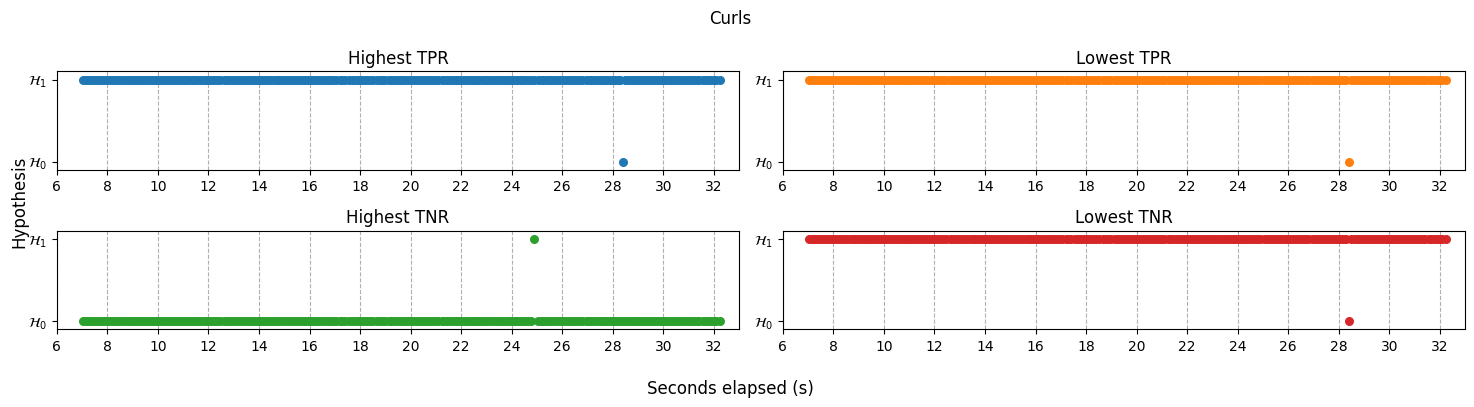

In [64]:
# Quad plot for highest TP, lowest TP, highest TN, lowest TN
hyps_quad_plot(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmax(curl_true_pos_arr)],
    curl_hyp_sets[np.argmin(curl_true_pos_arr)],
    curl_hyp_sets[np.argmax(curl_true_neg_arr)],
    curl_hyp_sets[np.argmin(curl_true_neg_arr)],
    curl_left_lim,
    curl_right_lim,
    ["Highest TPR", "Lowest TPR", "Highest TNR", "Lowest TNR"],
    s=dot_size
)
plt.suptitle("Curls")
plt.tight_layout()

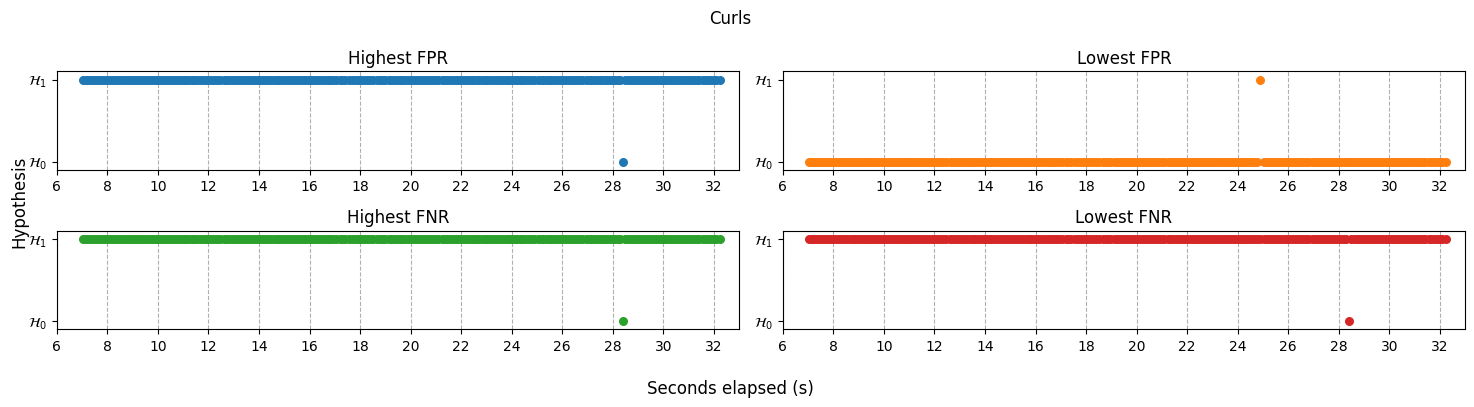

In [65]:
# Quad plot for highest FP, lowest FP, highest FN, lowest FN
hyps_quad_plot(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmax(curl_false_pos_arr)],
    curl_hyp_sets[np.argmin(curl_false_pos_arr)],
    curl_hyp_sets[np.argmax(curl_false_neg_arr)],
    curl_hyp_sets[np.argmin(curl_false_neg_arr)],
    curl_left_lim,
    curl_right_lim,
    ["Highest FPR", "Lowest FPR", "Highest FNR", "Lowest FNR"],
    s=dot_size
)
plt.suptitle("Curls")
plt.tight_layout()

##### Octa plot

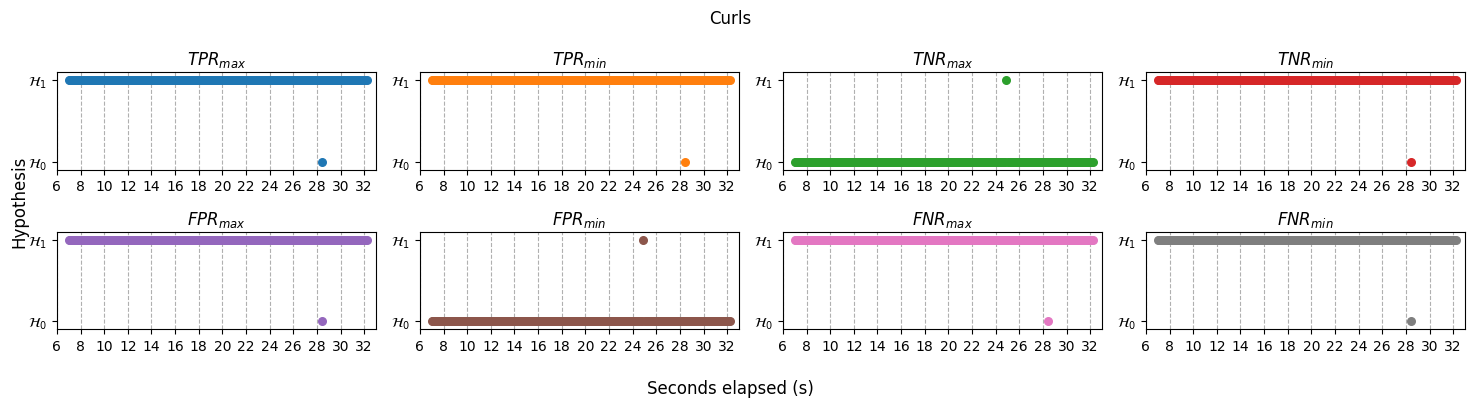

In [66]:
# Curls octa plot for max and min of all 8 metrics
hyps_octa_plot(
    curls_df_trim_s10["seconds_elapsed"],
    curl_hyp_sets[np.argmax(curl_true_pos_arr)],
    curl_hyp_sets[np.argmin(curl_true_pos_arr)],
    curl_hyp_sets[np.argmax(curl_true_neg_arr)],
    curl_hyp_sets[np.argmin(curl_true_neg_arr)],
    curl_hyp_sets[np.argmax(curl_false_pos_arr)],
    curl_hyp_sets[np.argmin(curl_false_pos_arr)],
    curl_hyp_sets[np.argmax(curl_false_neg_arr)],
    curl_hyp_sets[np.argmin(curl_false_neg_arr)],
    curl_left_lim,
    curl_right_lim,
    ["$TPR_{max}$", "$TPR_{min}$", "$TNR_{max}$", "$TNR_{min}$", "$FPR_{max}$", "$FPR_{min}$", "$FNR_{max}$", "$FNR_{min}$"],
    s=dot_size
)
plt.suptitle("Curls")
plt.tight_layout()

##### Key takeaways
- There are never any true positives, or false negatives.
    - There can be no true positives because NONE of the motion is translative, therefore at all moments the hypothesis is $\mathcal{H}_0$.
    - You can never be wrong to classify a window as $\mathcal{H}_0$, therefore there can be no false negatives either.
- The highest precision is 1.0.
- All recalls are 1.0.
- These metrics don't really seem to apply.
- Not much insight to be gathered from an exercise that's just always $\mathcal{H}_0$
- Does this mean it's pretty good at telling when a motion is **not** translational?

# Again: 50/10
50 window size, 10 stride.

## Compute test statistics

In [67]:
# squat_Ts_50_10 = min_min_evs(measurement_window(squat_df_trim, 50, stride=10))
squat_Ts_50_10 = pd.read_csv("data/sam/squat_Ts_50_10.csv").to_numpy().flatten()

In [68]:
# curl_Ts_50_10 = min_min_evs(measurement_window(curls_df_trim, 50, stride=10))
curl_Ts_50_10 = pd.read_csv("data/sam/curl_Ts_50_10.csv").to_numpy().flatten()

In [69]:
print(f"Squats Ts: {len(squat_Ts_50_10)}")
print(f"Curls Ts: {len(curl_Ts_50_10)}")

print(squat_df_trim_s10["hypothesis"].shape)

Squats Ts: 184
Curls Ts: 231
(184,)


In [70]:
# Trim the Ts to the length of the hypotheses
squat_Ts_50_10 = squat_Ts_50_10[:len(squat_df_trim_s10)]
curl_Ts_50_10 = curl_Ts_50_10[:len(curls_df_trim_s10)]

## Plot test statistics

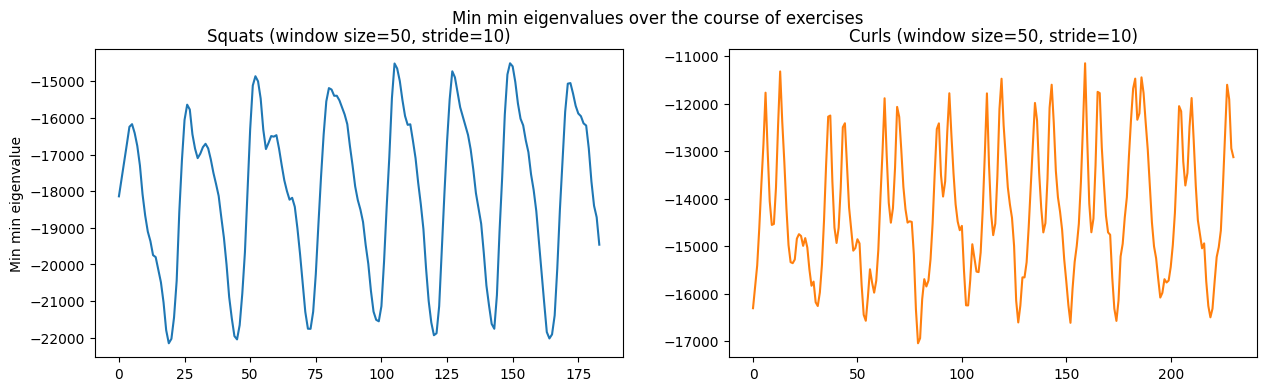

In [71]:
eigplot_double(
    squat_Ts_50_10,
    curl_Ts_50_10,
    "Squats",
    "Curls",
    50,
    50,
    10,
    10,
    "Min min eigenvalues over the course of exercises",
)

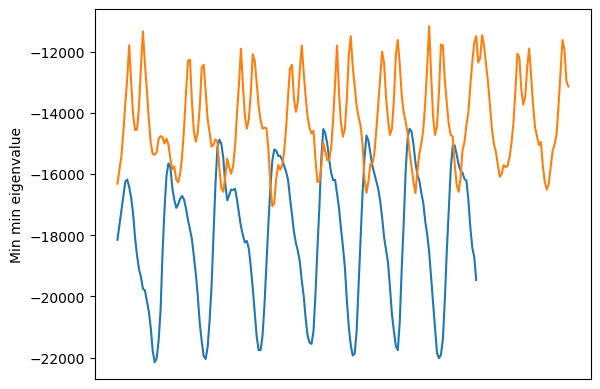

In [72]:
eigplot_two_together(squat_Ts_50_10, curl_Ts_50_10)

## Grid search gammas

### Squats

In [73]:
squat_50_10_gamma_lower = np.min(squat_Ts_50_10)
squat_50_10_gamma_upper = np.max(squat_Ts_50_10)
squat_50_10_gamma_step = 1

(
    squat_50_10_gammas,
    squat_50_10_accs_arr,
    squat_50_10_true_pos_arr,
    squat_50_10_false_pos_arr,
    squat_50_10_true_neg_arr,
    squat_50_10_false_neg_arr,
    squat_50_10_hyp_sets,
) = grid_search_gammas(
    squat_Ts_50_10,
    squat_df_trim_s10["hypothesis"].values,
    squat_50_10_gamma_lower,
    squat_50_10_gamma_upper,
    squat_50_10_gamma_step,
)

### Curls

In [74]:
curl_50_10_gamma_lower = np.min(curl_Ts_50_10)
curl_50_10_gamma_upper = np.max(curl_Ts_50_10)
curl_50_10_gamma_step = 1

(
    curl_50_10_gammas,
    curl_50_10_accs_arr,
    curl_50_10_true_pos_arr,
    curl_50_10_false_pos_arr,
    curl_50_10_true_neg_arr,
    curl_50_10_false_neg_arr,
    curl_50_10_hyp_sets,
) = grid_search_gammas(
    curl_Ts_50_10,
    curls_df_trim_s10["hypothesis"].values,
    curl_50_10_gamma_lower,
    curl_50_10_gamma_upper,
    curl_50_10_gamma_step,
)

## Plot classification metrics

### Squats

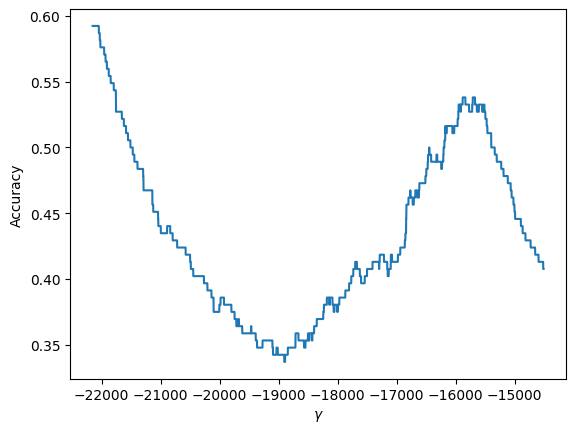

In [75]:
plt.xlabel("$\gamma$")
plt.ylabel("Accuracy")
ax = plt.plot(squat_50_10_gammas, squat_50_10_accs_arr)

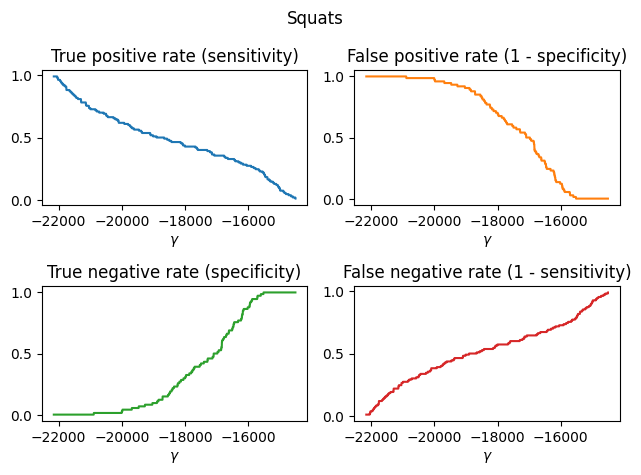

In [76]:
t = plt.suptitle("Squats")
plot_class_metrics(
    squat_50_10_gammas,
    squat_50_10_true_pos_arr,
    squat_50_10_false_pos_arr,
    squat_50_10_true_neg_arr,
    squat_50_10_false_neg_arr,
)

In [77]:
print(f"The first value in accuracies: {squat_50_10_accs_arr[0]}")
print(f"The highest accuracy: {np.max(squat_50_10_accs_arr)}")
print(f"The proportion of hypotheses that are 1: {np.mean(squat_df_trim_s10['hypothesis'])}")

The first value in accuracies: 0.592391304347826
The highest accuracy: 0.592391304347826
The proportion of hypotheses that are 1: 0.5978260869565217


### Curls

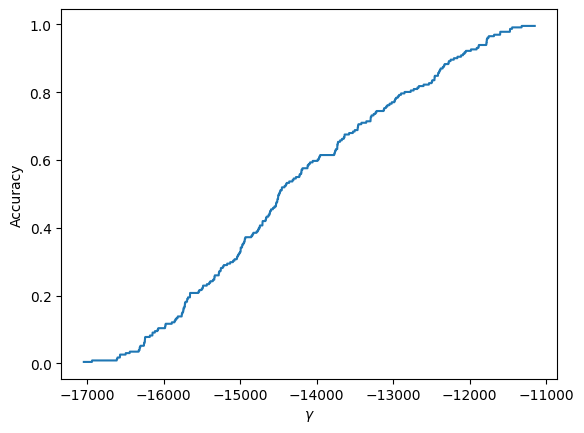

In [78]:
plt.xlabel("$\gamma$")
plt.ylabel("Accuracy")
ax = plt.plot(curl_50_10_gammas, curl_50_10_accs_arr)

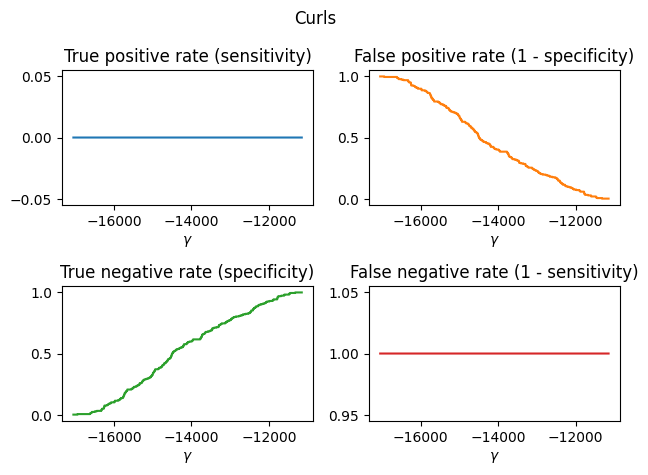

In [79]:
t = plt.suptitle("Curls")
plot_class_metrics(
    curl_50_10_gammas,
    curl_50_10_true_pos_arr,
    curl_50_10_false_pos_arr,
    curl_50_10_true_neg_arr,
    curl_50_10_false_neg_arr,
)

## Plot hypotheses

### Squats

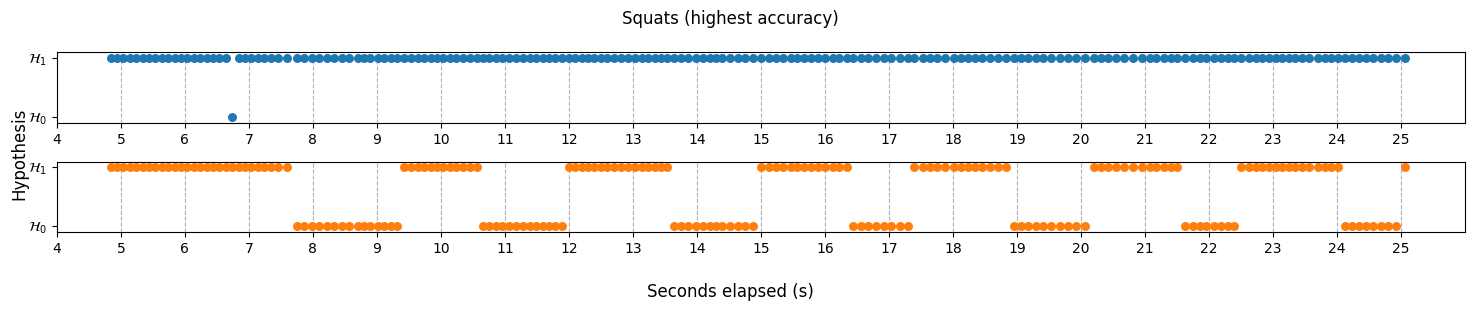

In [80]:
# Highest accuracy
side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"],
    squat_50_10_hyp_sets[np.argmax(squat_50_10_accs_arr)],
    squat_df_trim_s10["hypothesis"],
    4,
    26,
    s=dot_size
)
plt.suptitle("Squats (highest accuracy)")
plt.tight_layout()

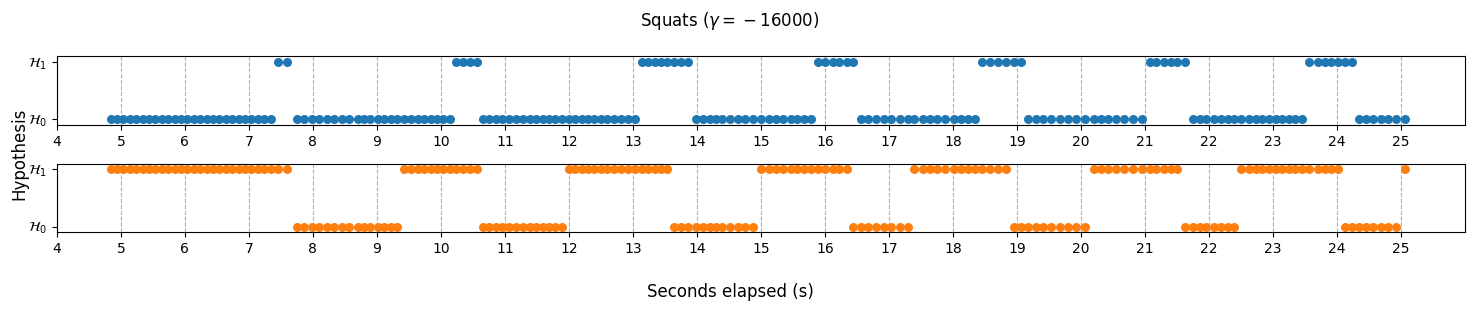

In [81]:
# Plot where gamma = -16000
# Convert gamma -16000 to position between upper and lower gamma bunds
idx = int((-16000 - squat_50_10_gamma_lower) / squat_50_10_gamma_step)

side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"],
    squat_50_10_hyp_sets[idx],
    squat_df_trim_s10["hypothesis"],
    4,
    26,
    s=dot_size
)
plt.suptitle("Squats ($\gamma = -16000$)")
plt.tight_layout()

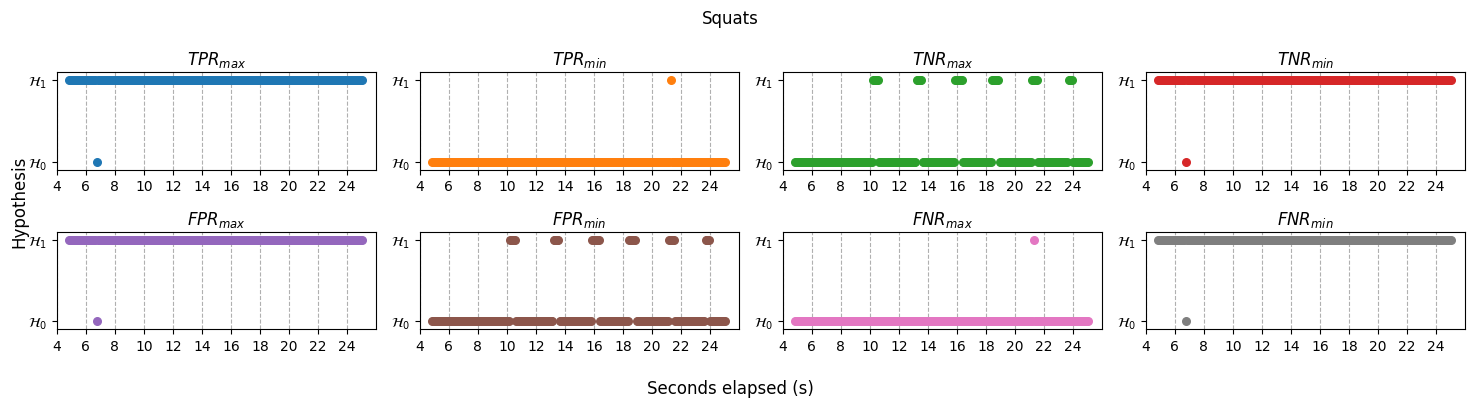

In [82]:
# Squats octa plot
hyps_octa_plot(
    squat_df_trim_s10["seconds_elapsed"],
    squat_50_10_hyp_sets[np.argmax(squat_50_10_true_pos_arr)],
    squat_50_10_hyp_sets[np.argmin(squat_50_10_true_pos_arr)],
    squat_50_10_hyp_sets[np.argmax(squat_50_10_true_neg_arr)],
    squat_50_10_hyp_sets[np.argmin(squat_50_10_true_neg_arr)],
    squat_50_10_hyp_sets[np.argmax(squat_50_10_false_pos_arr)],
    squat_50_10_hyp_sets[np.argmin(squat_50_10_false_pos_arr)],
    squat_50_10_hyp_sets[np.argmax(squat_50_10_false_neg_arr)],
    squat_50_10_hyp_sets[np.argmin(squat_50_10_false_neg_arr)],
    4,
    26,
    ["$TPR_{max}$", "$TPR_{min}$", "$TNR_{max}$", "$TNR_{min}$", "$FPR_{max}$", "$FPR_{min}$", "$FNR_{max}$", "$FNR_{min}$"],
    s=dot_size
)
plt.suptitle("Squats")
plt.tight_layout()

### Curls

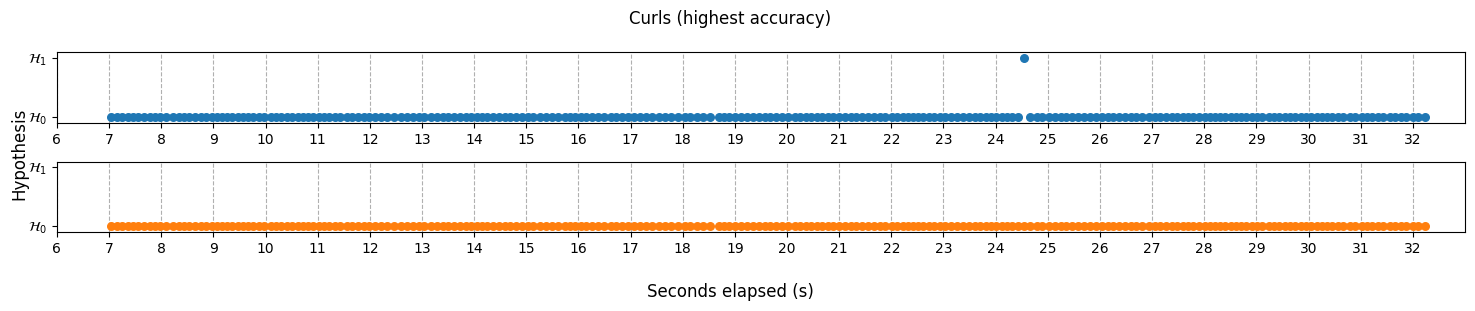

In [83]:
# Highest accuracy
side_by_side_hyps(
    curls_df_trim_s10["seconds_elapsed"],
    curl_50_10_hyp_sets[np.argmax(curl_50_10_accs_arr)],
    curls_df_trim_s10["hypothesis"],
    curl_left_lim,
    curl_right_lim,
    s=dot_size
)
plt.suptitle("Curls (highest accuracy)")
plt.tight_layout()

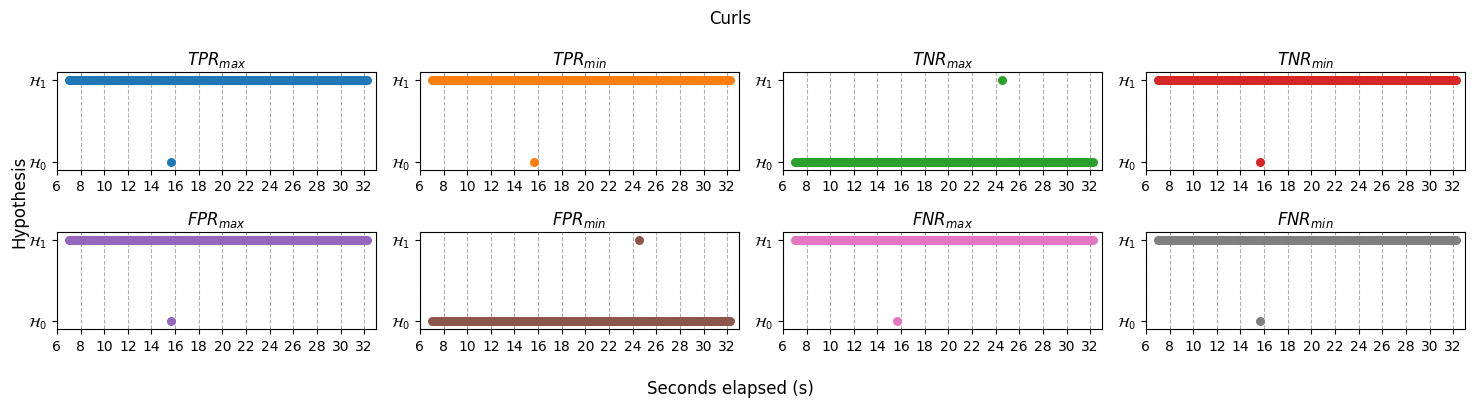

In [84]:
# Curls octa plot
hyps_octa_plot(
    curls_df_trim_s10["seconds_elapsed"],
    curl_50_10_hyp_sets[np.argmax(curl_50_10_true_pos_arr)],
    curl_50_10_hyp_sets[np.argmin(curl_50_10_true_pos_arr)],
    curl_50_10_hyp_sets[np.argmax(curl_50_10_true_neg_arr)],
    curl_50_10_hyp_sets[np.argmin(curl_50_10_true_neg_arr)],
    curl_50_10_hyp_sets[np.argmax(curl_50_10_false_pos_arr)],
    curl_50_10_hyp_sets[np.argmin(curl_50_10_false_pos_arr)],
    curl_50_10_hyp_sets[np.argmax(curl_50_10_false_neg_arr)],
    curl_50_10_hyp_sets[np.argmin(curl_50_10_false_neg_arr)],
    curl_left_lim,
    curl_right_lim,
    ["$TPR_{max}$", "$TPR_{min}$", "$TNR_{max}$", "$TNR_{min}$", "$FPR_{max}$", "$FPR_{min}$", "$FNR_{max}$", "$FNR_{min}$"],
    s=dot_size
)
plt.suptitle("Curls")
plt.tight_layout()

# Again: 150/10

## Compute test statistics

In [85]:
# squat_Ts_150_10 = min_min_evs(measurement_window(squat_df_trim, 150, stride=10))
squat_Ts_150_10 = pd.read_csv("data/sam/squat_Ts_150_10.csv").to_numpy().flatten()

In [86]:
# curl_Ts_150_10 = min_min_evs(measurement_window(curls_df_trim, 150, stride=10))
curl_Ts_150_10 = pd.read_csv("data/sam/curl_Ts_150_10.csv").to_numpy().flatten()

In [87]:
print(f"Squats Ts: {len(squat_Ts_150_10)}")
print(f"Curls Ts: {len(curl_Ts_150_10)}")

print(squat_df_trim_s10["hypothesis"].shape)

Squats Ts: 179
Curls Ts: 226
(184,)


## Plot test statistics

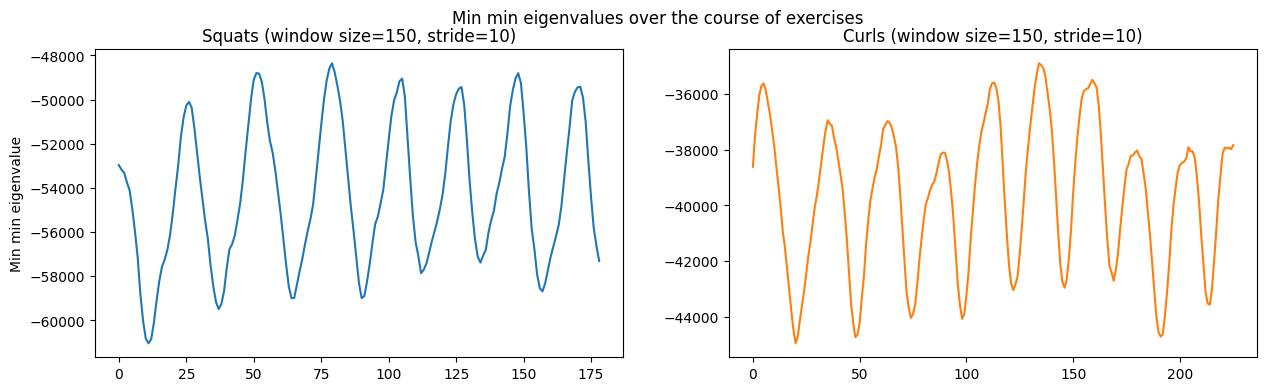

In [88]:
eigplot_double(
    squat_Ts_150_10,
    curl_Ts_150_10,
    "Squats",
    "Curls",
    150,
    150,
    10,
    10,
    "Min min eigenvalues over the course of exercises",
)

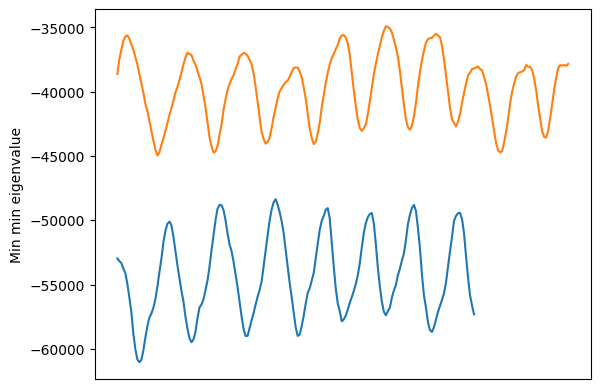

In [89]:
eigplot_two_together(squat_Ts_150_10, curl_Ts_150_10)

## Grid search gammas

### Squats

In [90]:
squat_150_10_gamma_lower = np.min(squat_Ts_150_10)
squat_150_10_gamma_upper = np.max(squat_Ts_150_10)
squat_150_10_gamma_step = 1

(
    squat_150_10_gammas,
    squat_150_10_accs_arr,
    squat_150_10_true_pos_arr,
    squat_150_10_false_pos_arr,
    squat_150_10_true_neg_arr,
    squat_150_10_false_neg_arr,
    squat_150_10_hyp_sets,
) = grid_search_gammas(
    squat_Ts_150_10,
    squat_df_trim_s10["hypothesis"].values[:len(squat_Ts_150_10)],
    squat_150_10_gamma_lower,
    squat_150_10_gamma_upper,
    squat_150_10_gamma_step,
)

### Curls

In [91]:
curl_150_10_gamma_lower = np.min(curl_Ts_150_10)
curl_150_10_gamma_upper = np.max(curl_Ts_150_10)
curl_150_10_gamma_step = 1

(
    curl_150_10_gammas,
    curl_150_10_accs_arr,
    curl_150_10_true_pos_arr,
    curl_150_10_false_pos_arr,
    curl_150_10_true_neg_arr,
    curl_150_10_false_neg_arr,
    curl_150_10_hyp_sets,
) = grid_search_gammas(
    curl_Ts_150_10,
    curls_df_trim_s10["hypothesis"].values[:len(curl_Ts_150_10)],
    curl_150_10_gamma_lower,
    curl_150_10_gamma_upper,
    curl_150_10_gamma_step,
)

## Plot classification metrics

### Squats

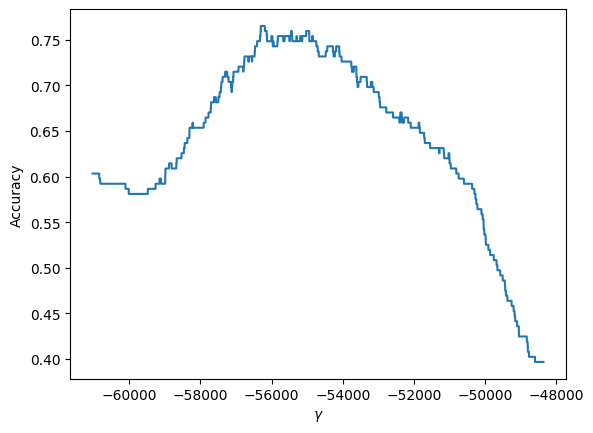

In [92]:
# Plot accuracy
plt.xlabel("$\gamma$")
plt.ylabel("Accuracy")
ax = plt.plot(squat_150_10_gammas, squat_150_10_accs_arr)

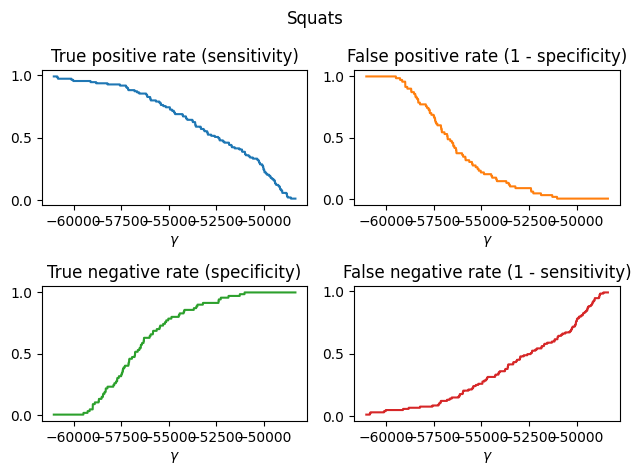

In [93]:
# Plot metrics
t = plt.suptitle("Squats")
plot_class_metrics(
    squat_150_10_gammas,
    squat_150_10_true_pos_arr,
    squat_150_10_false_pos_arr,
    squat_150_10_true_neg_arr,
    squat_150_10_false_neg_arr,
)

### Curls

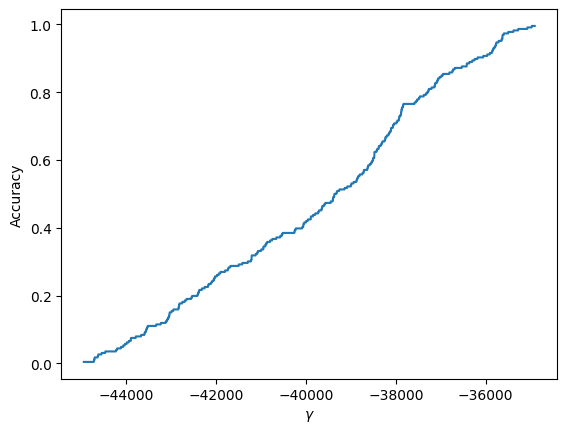

In [94]:
# Plot accuracy
plt.xlabel("$\gamma$")
plt.ylabel("Accuracy")
ax = plt.plot(curl_150_10_gammas, curl_150_10_accs_arr)

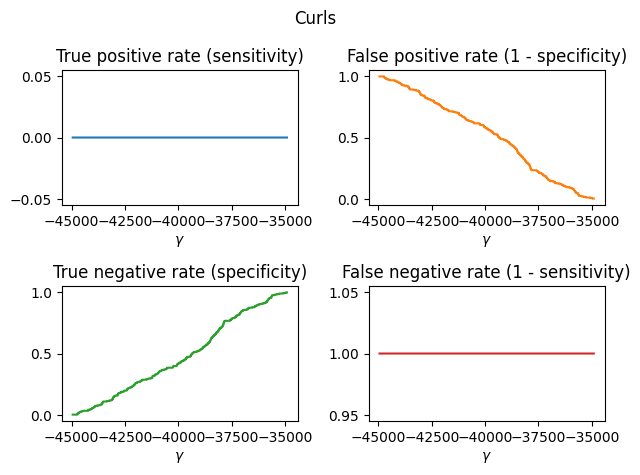

In [95]:
# Plot metrics
t = plt.suptitle("Curls")
plot_class_metrics(
    curl_150_10_gammas,
    curl_150_10_true_pos_arr,
    curl_150_10_false_pos_arr,
    curl_150_10_true_neg_arr,
    curl_150_10_false_neg_arr,
)

## Plot hypotheses

### Squats

Highest accuracy: 0.7653631284916201


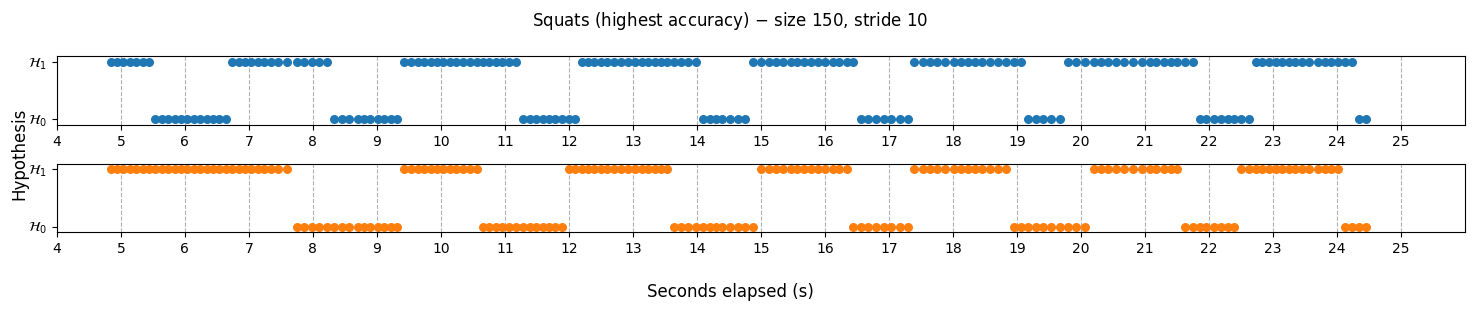

In [96]:
# Highest accuracy
print(f"Highest accuracy: {np.max(squat_150_10_accs_arr)}")
side_by_side_hyps(
    squat_df_trim_s10["seconds_elapsed"][:len(squat_Ts_150_10)],
    squat_150_10_hyp_sets[np.argmax(squat_150_10_accs_arr)],
    squat_df_trim_s10["hypothesis"][:len(squat_Ts_150_10)],
    4,
    26,
    s=dot_size
)
plt.suptitle("Squats (highest accuracy) $-$ size 150, stride 10")
plt.tight_layout()

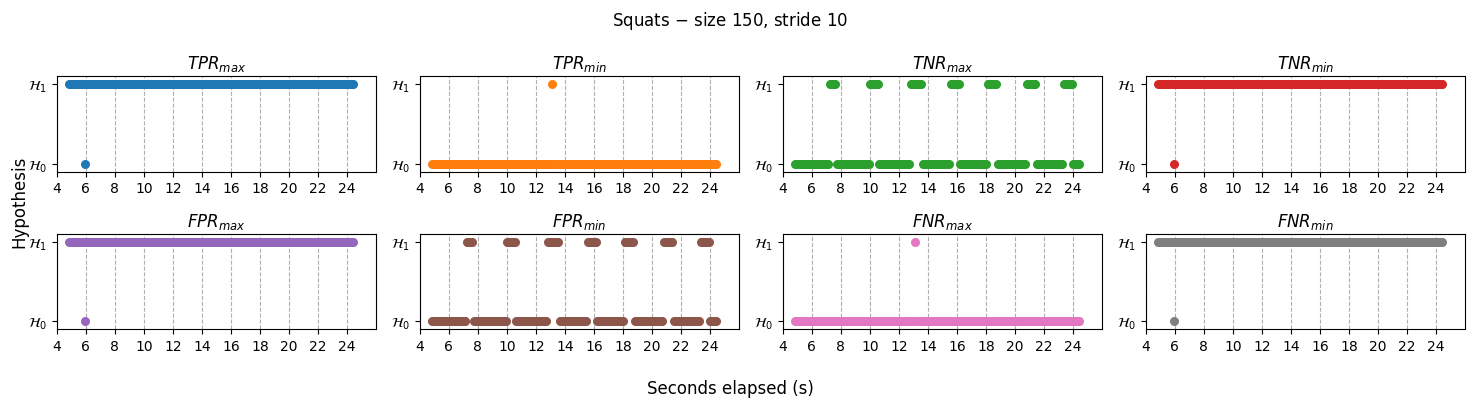

In [97]:
# Octa plot
hyps_octa_plot(
    squat_df_trim_s10["seconds_elapsed"][:len(squat_Ts_150_10)],
    squat_150_10_hyp_sets[np.argmax(squat_150_10_true_pos_arr)],
    squat_150_10_hyp_sets[np.argmin(squat_150_10_true_pos_arr)],
    squat_150_10_hyp_sets[np.argmax(squat_150_10_true_neg_arr)],
    squat_150_10_hyp_sets[np.argmin(squat_150_10_true_neg_arr)],
    squat_150_10_hyp_sets[np.argmax(squat_150_10_false_pos_arr)],
    squat_150_10_hyp_sets[np.argmin(squat_150_10_false_pos_arr)],
    squat_150_10_hyp_sets[np.argmax(squat_150_10_false_neg_arr)],
    squat_150_10_hyp_sets[np.argmin(squat_150_10_false_neg_arr)],
    4,
    26,
    ["$TPR_{max}$", "$TPR_{min}$", "$TNR_{max}$", "$TNR_{min}$", "$FPR_{max}$", "$FPR_{min}$", "$FNR_{max}$", "$FNR_{min}$"],
    s=dot_size
)
plt.suptitle("Squats $-$ size 150, stride 10")
plt.tight_layout()

### Curls

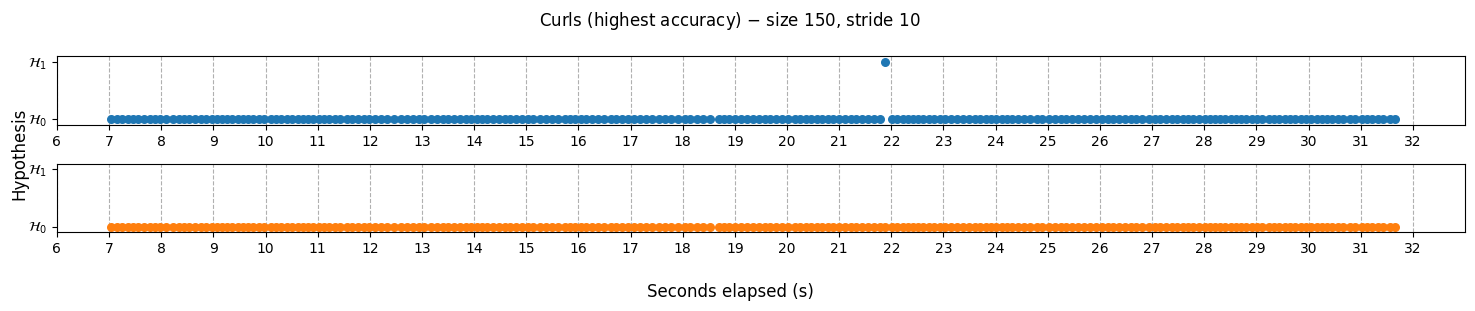

In [98]:
# Highest accuracy
side_by_side_hyps(
    curls_df_trim_s10["seconds_elapsed"][:len(curl_Ts_150_10)],
    curl_150_10_hyp_sets[np.argmax(curl_150_10_accs_arr)],
    curls_df_trim_s10["hypothesis"][:len(curl_Ts_150_10)],
    curl_left_lim,
    curl_right_lim,
    s=dot_size
)
plt.suptitle("Curls (highest accuracy) $-$ size 150, stride 10")
plt.tight_layout()

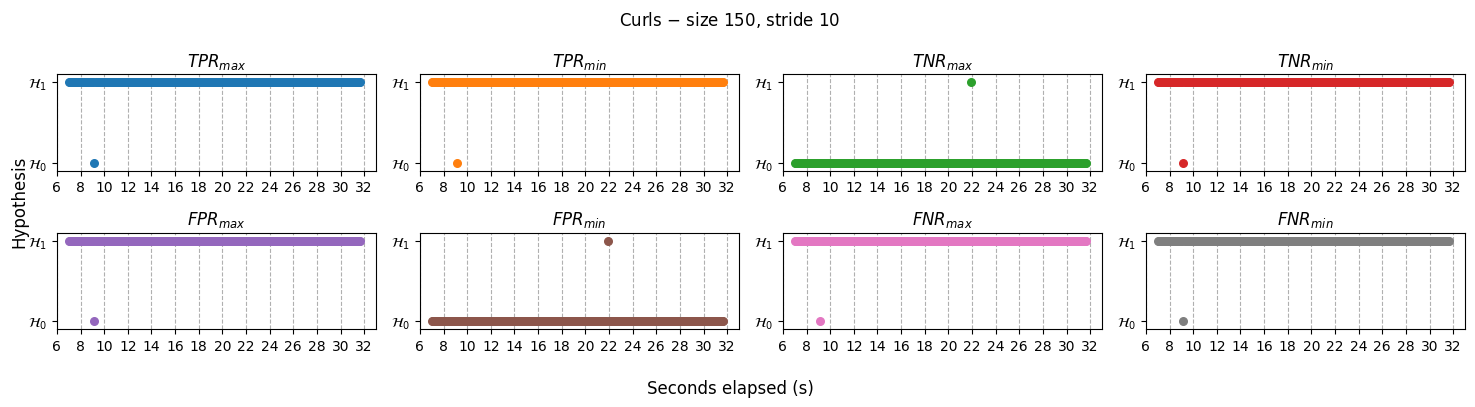

In [99]:
# Octa plot
hyps_octa_plot(
    curls_df_trim_s10["seconds_elapsed"][:len(curl_Ts_150_10)],
    curl_150_10_hyp_sets[np.argmax(curl_150_10_true_pos_arr)],
    curl_150_10_hyp_sets[np.argmin(curl_150_10_true_pos_arr)],
    curl_150_10_hyp_sets[np.argmax(curl_150_10_true_neg_arr)],
    curl_150_10_hyp_sets[np.argmin(curl_150_10_true_neg_arr)],
    curl_150_10_hyp_sets[np.argmax(curl_150_10_false_pos_arr)],
    curl_150_10_hyp_sets[np.argmin(curl_150_10_false_pos_arr)],
    curl_150_10_hyp_sets[np.argmax(curl_150_10_false_neg_arr)],
    curl_150_10_hyp_sets[np.argmin(curl_150_10_false_neg_arr)],
    curl_left_lim,
    curl_right_lim,
    ["$TPR_{max}$", "$TPR_{min}$", "$TNR_{max}$", "$TNR_{min}$", "$FPR_{max}$", "$FPR_{min}$", "$FNR_{max}$", "$FNR_{min}$"],
    s=dot_size
)
plt.suptitle("Curls $-$ size 150, stride 10")
plt.tight_layout()

# Again: 150/25

In [100]:
# Apply 25 stride to squat and curl data
squat_df_trim_s25 = squat_df_trim[::25]
curls_df_trim_s25 = curls_df_trim[::25]

## Compute test statistics

In [101]:
# squat_Ts_150_25 = min_min_evs(measurement_window(squat_df_trim, 150, stride=25))
squat_Ts_150_25 = pd.read_csv("data/sam/squat_Ts_150_25.csv").to_numpy().flatten()

In [102]:
# curl_Ts_150_25 = min_min_evs(measurement_window(curls_df_trim, 150, stride=25))
curl_Ts_150_25 = pd.read_csv("data/sam/curl_Ts_150_25.csv").to_numpy().flatten()

In [103]:
print(f"Squats Ts: {len(squat_Ts_150_25)}")
print(f"Curls Ts: {len(curl_Ts_150_25)}")

print(squat_df_trim_s25["hypothesis"].shape)
print(curls_df_trim_s25["hypothesis"].shape)
# The DFs needs to be trimmed

Squats Ts: 72
Curls Ts: 91
(78,)
(97,)


## Plot test statistics

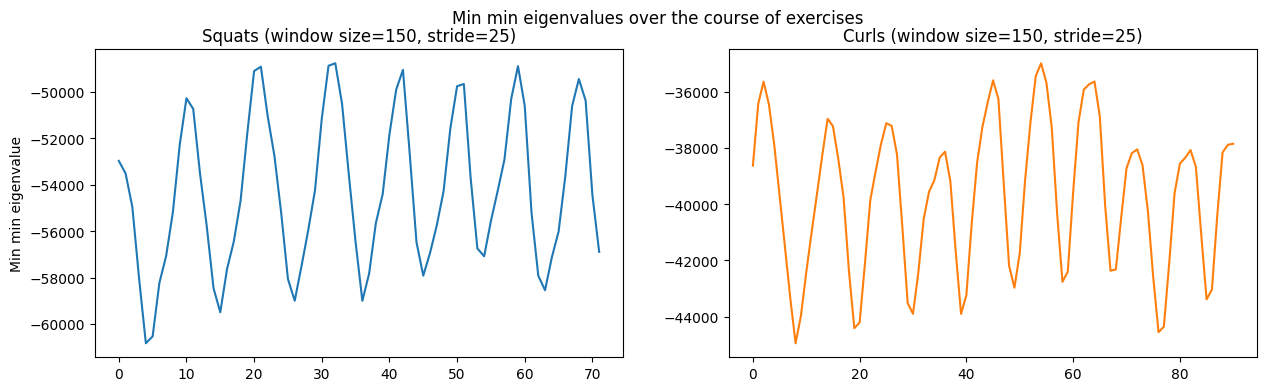

In [104]:
eigplot_double(
    squat_Ts_150_25,
    curl_Ts_150_25,
    "Squats",
    "Curls",
    150,
    150,
    25,
    25,
    "Min min eigenvalues over the course of exercises",
)

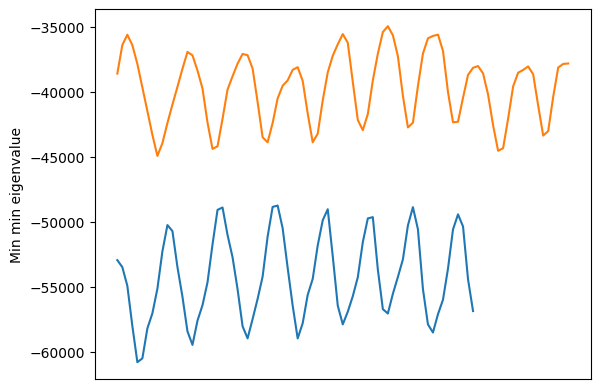

In [105]:
eigplot_two_together(squat_Ts_150_25, curl_Ts_150_25)

## Grid search gammas

### Squats

In [106]:
squat_150_25_gamma_lower = np.min(squat_Ts_150_25)
squat_150_25_gamma_upper = np.max(squat_Ts_150_25)
squat_150_25_gamma_step = 1

(
    squat_150_25_gammas,
    squat_150_25_accs_arr,
    squat_150_25_true_pos_arr,
    squat_150_25_false_pos_arr,
    squat_150_25_true_neg_arr,
    squat_150_25_false_neg_arr,
    squat_150_25_hyp_sets,
) = grid_search_gammas(
    squat_Ts_150_25,
    squat_df_trim_s25["hypothesis"].values[:len(squat_Ts_150_25)],
    squat_150_25_gamma_lower,
    squat_150_25_gamma_upper,
    squat_150_25_gamma_step,
)

### Curls

In [107]:
curl_150_25_gamma_lower = np.min(curl_Ts_150_25)
curl_150_25_gamma_upper = np.max(curl_Ts_150_25)
curl_150_25_gamma_step = 1

(
    curl_150_25_gammas,
    curl_150_25_accs_arr,
    curl_150_25_true_pos_arr,
    curl_150_25_false_pos_arr,
    curl_150_25_true_neg_arr,
    curl_150_25_false_neg_arr,
    curl_150_25_hyp_sets,
) = grid_search_gammas(
    curl_Ts_150_25,
    curls_df_trim_s25["hypothesis"].values[:len(curl_Ts_150_25)],
    curl_150_25_gamma_lower,
    curl_150_25_gamma_upper,
    curl_150_25_gamma_step,
)

## Plot classification metrics

### Squats

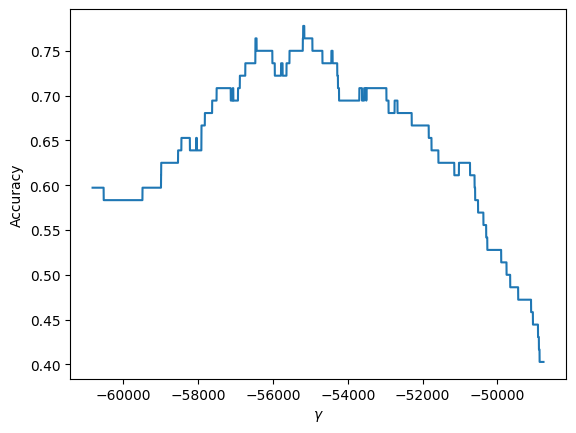

In [108]:
# Accuracy
plt.xlabel("$\gamma$")
plt.ylabel("Accuracy")
ax = plt.plot(squat_150_25_gammas, squat_150_25_accs_arr)

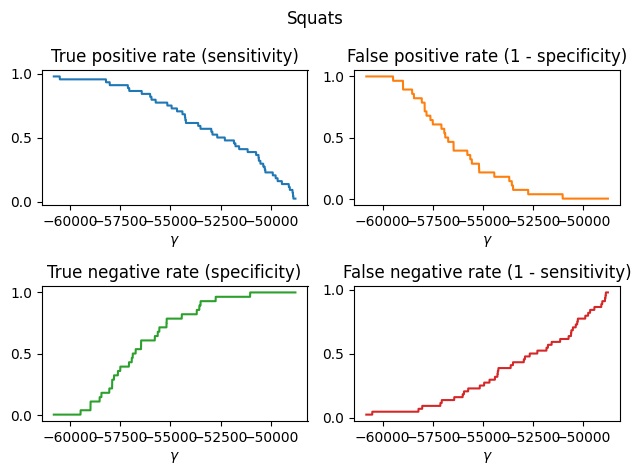

In [109]:
# Plot metrics
t = plt.suptitle("Squats")
plot_class_metrics(
    squat_150_25_gammas,
    squat_150_25_true_pos_arr,
    squat_150_25_false_pos_arr,
    squat_150_25_true_neg_arr,
    squat_150_25_false_neg_arr,
)

### Curls

Too boring to bother with

## Plot hypotheses

### Squats

Highest accuracy: 0.7777777777777778


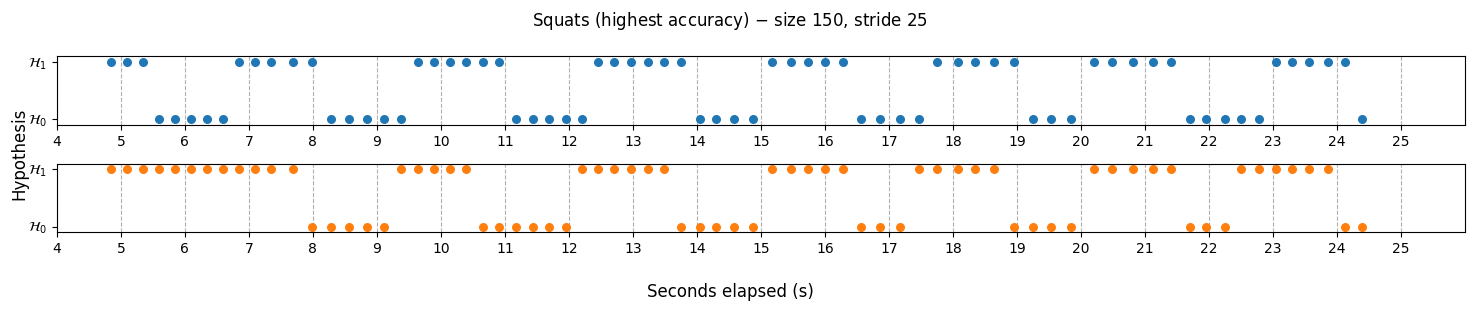

In [110]:
# Highest accuracy
print(f"Highest accuracy: {np.max(squat_150_25_accs_arr)}")
side_by_side_hyps(
    squat_df_trim_s25["seconds_elapsed"][:len(squat_Ts_150_25)],
    squat_150_25_hyp_sets[np.argmax(squat_150_25_accs_arr)],
    squat_df_trim_s25["hypothesis"][:len(squat_Ts_150_25)],
    4,
    26,
    s=dot_size
)
plt.suptitle("Squats (highest accuracy) $-$ size 150, stride 25")
plt.tight_layout()

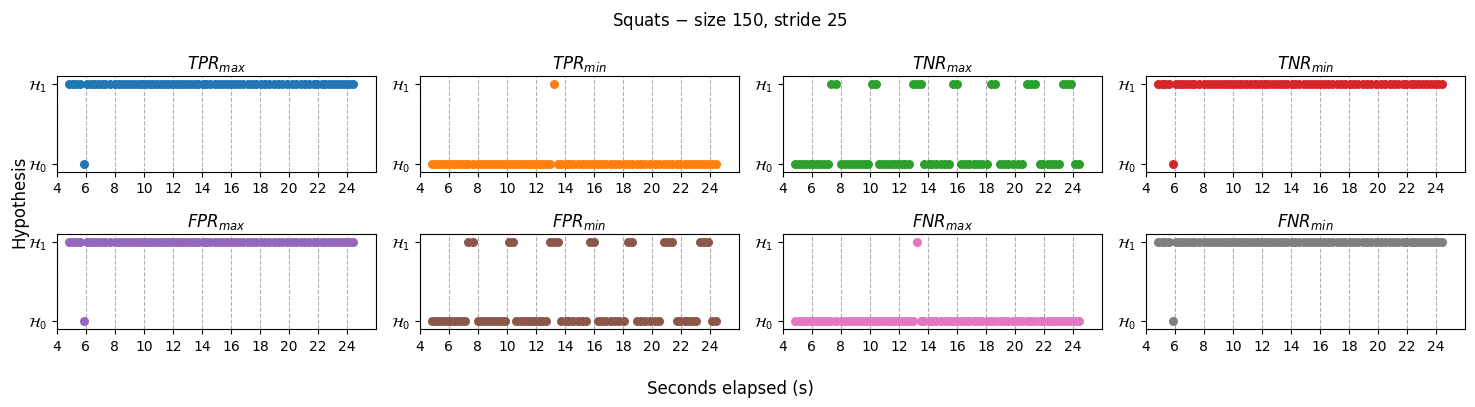

In [111]:
# Octa plot
hyps_octa_plot(
    squat_df_trim_s25["seconds_elapsed"][:len(squat_Ts_150_25)],
    squat_150_25_hyp_sets[np.argmax(squat_150_25_true_pos_arr)],
    squat_150_25_hyp_sets[np.argmin(squat_150_25_true_pos_arr)],
    squat_150_25_hyp_sets[np.argmax(squat_150_25_true_neg_arr)],
    squat_150_25_hyp_sets[np.argmin(squat_150_25_true_neg_arr)],
    squat_150_25_hyp_sets[np.argmax(squat_150_25_false_pos_arr)],
    squat_150_25_hyp_sets[np.argmin(squat_150_25_false_pos_arr)],
    squat_150_25_hyp_sets[np.argmax(squat_150_25_false_neg_arr)],
    squat_150_25_hyp_sets[np.argmin(squat_150_25_false_neg_arr)],
    4,
    26,
    ["$TPR_{max}$", "$TPR_{min}$", "$TNR_{max}$", "$TNR_{min}$", "$FPR_{max}$", "$FPR_{min}$", "$FNR_{max}$", "$FNR_{min}$"],
    s=dot_size
)
plt.suptitle("Squats $-$ size 150, stride 25")
plt.tight_layout()

### Curls

Too boring to do again

# Inter-experiment comparison

## Line plots of accuracy vs $\gamma$ by window size and stride

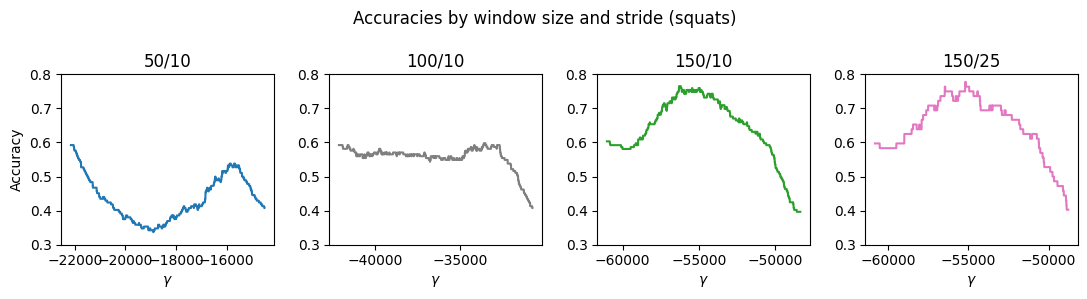

In [130]:
fig = plt.figure(figsize=(11, 3))

# 50/10
plt.subplot(1, 4, 1)
plt.ylim(0.3, 0.8)
plt.plot(squat_50_10_gammas, squat_50_10_accs_arr, color="tab:blue")
plt.title("50/10")
plt.ylabel("Accuracy")
plt.xlabel("$\gamma$")

# 100/10
plt.subplot(1, 4, 2)
plt.ylim(0.3, 0.8)
plt.plot(squat_gammas, squat_accs_arr, color="tab:grey")
plt.title("100/10")
plt.xlabel("$\gamma$")

# 150/10
plt.subplot(1, 4, 3)
plt.ylim(0.3, 0.8)
plt.plot(squat_150_10_gammas, squat_150_10_accs_arr, color="tab:green")
plt.title("150/10")
plt.xlabel("$\gamma$")

# 150/25
plt.subplot(1, 4, 4)
plt.ylim(0.3, 0.8)
plt.plot(squat_150_25_gammas, squat_150_25_accs_arr, color="tab:pink")
plt.title("150/25")
plt.xlabel("$\gamma$")

plt.suptitle("Accuracies by window size and stride (squats)")
plt.tight_layout()

## Hypothesis plots of max accuracy hypothesis sets by window size and stride

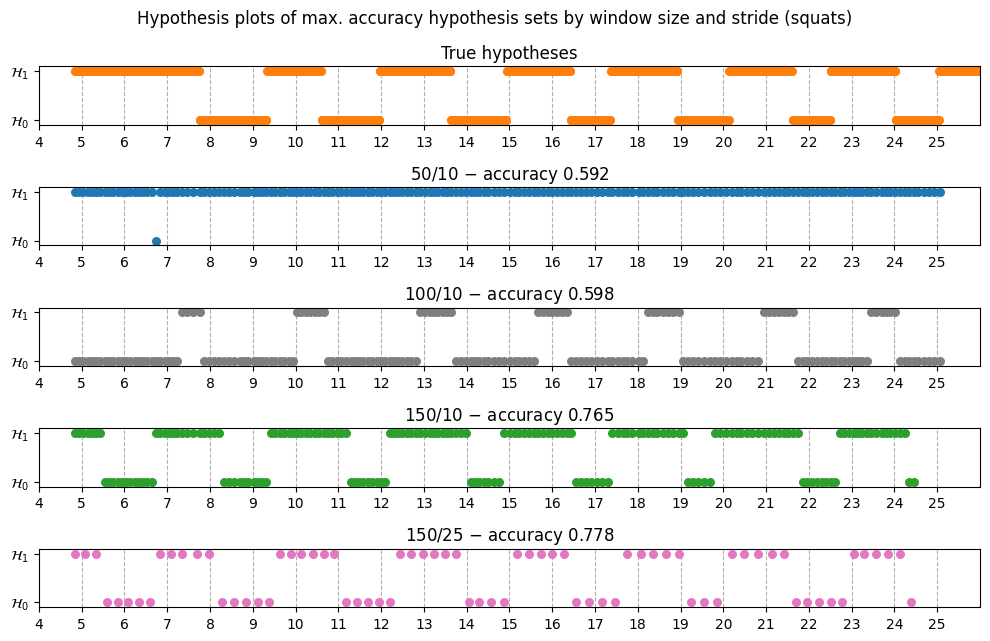

In [128]:
fig = plt.figure(figsize=(10, 6.5))
plt.suptitle(
    "Hypothesis plots of max. accuracy hypothesis sets by window size and stride (squats)"
)

# True hypotheses
plt.subplot(5, 1, 1)
plt.title("True hypotheses")
plot_hypotheses(
    squat_df_trim["seconds_elapsed"],
    squat_df_trim["hypothesis"],
    4,
    26,
    s=dot_size,
    color="tab:orange",
)

# 50/10
plt.subplot(5, 1, 2)
plt.title(f"50/10 $-$ accuracy {np.max(squat_50_10_accs_arr):.3f}")
plot_hypotheses(
    squat_df_trim_s10["seconds_elapsed"],
    squat_50_10_hyp_sets[np.argmax(squat_50_10_accs_arr)],
    4,
    26,
    s=dot_size,
    color="tab:blue",
)

# 100/10
plt.subplot(5, 1, 3)
plt.title(f"100/10 $-$ accuracy {np.max(squat_accs_arr):.3f}")
plot_hypotheses(
    squat_df_trim_s10["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_accs_arr)],
    4,
    26,
    s=dot_size,
    color="tab:grey",
)

# 150/10
plt.subplot(5, 1, 4)
plt.title(f"150/10 $-$ accuracy {np.max(squat_150_10_accs_arr):.3f}")
plot_hypotheses(
    squat_df_trim_s10["seconds_elapsed"][: len(squat_150_10_hyp_sets[0])],
    squat_150_10_hyp_sets[np.argmax(squat_150_10_accs_arr)],
    4,
    26,
    s=dot_size,
    color="tab:green",
)

# 150/25
plt.subplot(5, 1, 5)
plt.title(f"150/25 $-$ accuracy {np.max(squat_150_25_accs_arr):.3f}")
plot_hypotheses(
    squat_df_trim_s25["seconds_elapsed"][: len(squat_150_25_hyp_sets[0])],
    squat_150_25_hyp_sets[np.argmax(squat_150_25_accs_arr)],
    4,
    26,
    s=dot_size,
    color="tab:pink",
)

plt.tight_layout()

## ROC curve

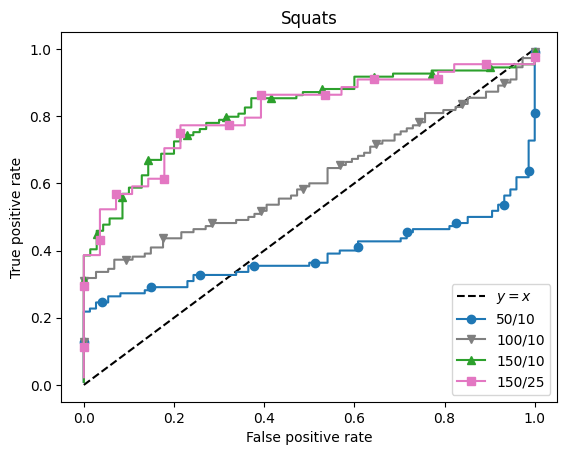

In [127]:
# y = x baseline
plt.plot([0, 1], [0, 1], color="black", linestyle="--", label="$y = x$")

# 50/10
plt.plot(
    squat_50_10_false_pos_arr,
    squat_50_10_true_pos_arr,
    "o",
    ls="-",
    color="tab:blue",
    label="50/10",
    markevery=0.1,
)

# 100/10
plt.plot(
    squat_false_pos_arr,
    squat_true_pos_arr,
    "v",
    ls="-",
    color="tab:grey",
    label="100/10",
    markevery=0.1,
)

# 150/10
plt.plot(
    squat_150_10_false_pos_arr,
    squat_150_10_true_pos_arr,
    "^",
    ls="-",
    color="tab:green",
    label="150/10",
    markevery=0.1,
)

# 150/25
plt.plot(
    squat_150_25_false_pos_arr,
    squat_150_25_true_pos_arr,
    "s",
    ls="-",
    color="tab:pink",
    label="150/25",
    markevery=0.1,
)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Squats")
l = plt.legend()

# To do

In [115]:
end_time = datetime.now()
print(f"Time taken: {end_time - start_time}")

Time taken: 0:00:51.533267
